# HLS Based Classification process for *Ventenata dubia*

This workflow uses data collected from fieldwork across the state of MT to train multiple classification ensemble models with Harmonized Landsat/Sentinel imagery and calculated vegetation indices.

Workflow:
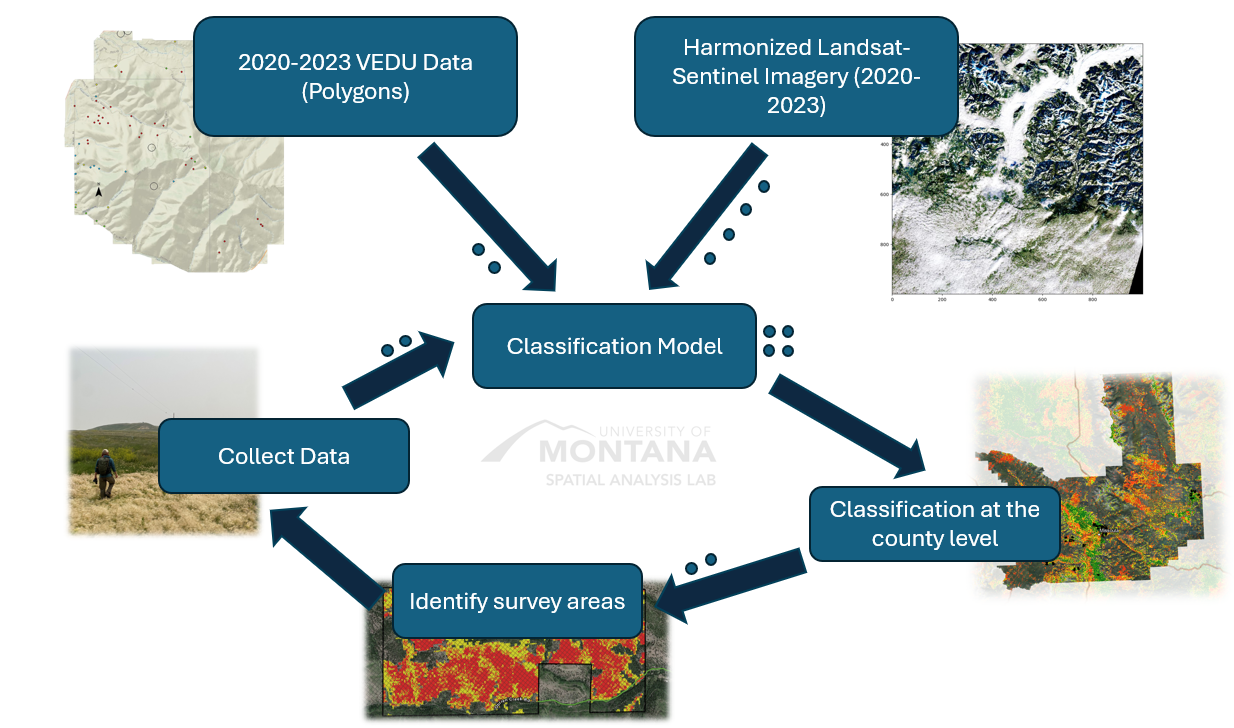

Starting off: Packages

Download the required packages to process the work. The commented lines (#...) are imports that really only need to be done once. If you're running this for the first time, remove the comment (delete the #) and run. Then if you run it in the future, you shouldn't need to re-download the package later.

Steps in the Extracted Code:
### Load and Process Geospatial Data:

### Reads a shapefile and reprojects it to a specified CRS (e.g., EPSG:5070).
Buffers polygons to expand their spatial coverage.
Merges these buffered polygons into groups using unary_union.
Generate Bounding Boxes:

### Extracts bounding boxes from the merged geometries.
Converts bounding boxes into a GeoDataFrame and assigns unique box_ids.
Visualization:

### Plots specific bounding boxes along with the polygons they contain to visually inspect the grouping and intersection.
HLS Data Search:

### Transforms bounding box coordinates to EPSG:4326 for compatibility with the NASA STAC API.
Searches for HLS (Harmonized Landsat and Sentinel-2) data using bounding box coordinates, temporal constraints, and cloud cover filters.
Renames spectral bands in the retrieved items for consistency.

In [2]:
!pwd

!which conda
!conda activate vedu_env
!which python
!python --version

import sys
print(sys.executable)

/Users/rustin/Documents/Spatial_Analysis_Lab/Ventenata
/opt/anaconda3/condabin/conda
/opt/anaconda3/envs/vedu_env/bin/python
Python 3.11.11
/opt/anaconda3/envs/vedu_env/bin/python


In [3]:
!conda activate vedu_env



CondaError: Run 'conda init' before 'conda activate'



In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio as rio
import pyproj
from shapely.ops import transform
import xarray as xr
import geoviews as gv
import stackstac
from shapely.geometry import box, Polygon, MultiPolygon
import folium
import bottleneck
import geocube
from geocube.api.core import make_geocube
import seaborn as sns
import pystac_client
import os
import numpy as np
import pandas as pd
import geopandas as gp
import rasterio as rio
import matplotlib.pyplot as plt
from osgeo import gdal
from shapely.geometry import box, Polygon, MultiPolygon
from shapely.ops import unary_union
import pyproj
from geocube.api.core import make_geocube
import earthaccess





/opt/anaconda3/envs/vedu_env/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [5]:
import os
os.environ['PROJ_LIB'] = '/opt/anaconda3/envs/vedu_env/share/proj'

This section is useful when we want to upload data from google drive. This step can be turned on or off (delete the #) at any time.

Similar to the list above, the earthaccess package is what allows us to import data from NASA's API. The earth access login *should* be unique to each of us, but this saves the step:

username: rbrassfield

password: YY82nHH4pD$$

In [2]:
!pip install --upgrade earthaccess
import earthaccess
earthaccess.login(persist=True)

  Using cached earthaccess-0.12.0-py3-none-any.whl.metadata (7.6 kB)
  Using cached multimethod-2.0-py3-none-any.whl.metadata (9.2 kB)
  Using cached pqdm-0.2.0-py2.py3-none-any.whl.metadata (3.2 kB)
  Using cached python_cmr-0.13.0-py3-none-any.whl.metadata (10 kB)
  Using cached s3fs-2024.12.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tinynetrc-1.3.1-py2.py3-none-any.whl.metadata (2.9 kB)
  Using cached bounded_pool_executor-0.0.3-py3-none-any.whl.metadata (2.7 kB)
  Using cached aioitertools-0.12.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
Using cached earthaccess-0.12.0-py3-none-any.whl (60 kB)
Using cached multimethod-2.0-py3-none-any.whl (9.8 kB)
Using cached pqdm-0.2.0-py2.py3-none-any.whl (6.8 kB)
Using cached python_cmr-0.13.0-py3-none-any.whl (14 kB)
Using cached s3fs-20

/opt/anaconda3/envs/vedu_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here is where we get into the nitty gritty work.

CMR_STAC_URL is the URL we tell the package pystac where to find the data we want.
We set the catalog to be this url perpetually to avoid setting it every time.

In [7]:


import pystac_client

CMR_STAC_URL = "https://cmr.earthdata.nasa.gov/stac/LPCLOUD"
catalog = pystac_client.Client.open(CMR_STAC_URL)

The "band crosswalk" basically converts the different band names (retained in the HLS request) to common language so when we reference the red band, it pulls the red band from both Sentinel and Landsat.

In [8]:
BAND_CROSSWALK = {
    "HLSL30_2.0": {
        "B01": "coastal aerosol",
        "B02": "blue",
        "B03": "green",
        "B04": "red",
        "B05": "nir_narrow",
        "B06": "swir_1",
        "B07": "swir_2",
        "B09": "cirrus",
        "B10": "thermal infrared 1",
        "B11": "thermal",
    },
    "HLSS30_2.0": {
        "B01": "coastal aerosol",
        "B02": "blue",
        "B03": "green",
        "B04": "red",
        "B05": "red-edge 1",
        "B06": "red-edge 2",
        "B07": "red-edge 3",
        "B08": "nir broad",
        "B8A": "nir_narrow",
        "B09": "water vapor",
        "B10": "cirrus",
        "B11": "swir_1",
        "B12": "swir_2",
    },
}

# these are the ones that we are going to use
BANDS = ["red", "green", "blue", "nir_narrow","swir_2","Fmask"]
b = ["B02","B03","B04","B8A","B12","Fmask"]
b2 = ["B02","B03","B04","B05","B07","Fmask"]

# Polygon and Bounding Box Loops

This section does a number of things. First, it pulls our vedu data from the drive, that file is the merged 2023-2024 data with slope and aspect in there. Starting in Line 11, we use a buffer to determine what polygons are close to each other. This method is useful, because it means fewer requests to the API, we've combined our polygon data to a nearby bounding box that we'll use to request imagery. We also create an index to reference both individual bounding boxes and all the polygons that fall inside the bounding box.

In [9]:
import rasterio

# Using the Env context manager to ensure a GDAL environment
with rasterio.Env():
    print("GDAL_DATA:", rasterio.env.getenv().get("GDAL_DATA"))
    print("PROJ_LIB:", rasterio.env.getenv().get("PROJ_LIB"))

GDAL_DATA: /opt/anaconda3/envs/vedu_env/share/gdal
PROJ_LIB: None


In [1]:
from pyproj import datadir
datadir.set_data_dir("/opt/anaconda3/envs/vedu_env/share/proj")

vedu = gp.read_file('/Users/rustin/Documents/Spatial_Analysis_Lab/Ventenata/Ventenata_Files/merge2324.shp')

print(vedu.shape)
print(vedu.head)

NameError: name 'gp' is not defined

In [11]:
from shapely.ops import unary_union
from shapely.geometry import MultiPolygon
from shapely.geometry import box

# Constants and Paths (fill these in as needed)
CRS_STRING = "epsg:5070"
START_DATE = "2023-04-01" #change/update if necessary
END_DATE = "2023-09-30"
# Load and reproject the shapefile to the target CRS
vedu = gp.read_file('/Users/rustin/Documents/Spatial_Analysis_Lab/Ventenata/Ventenata_Files/merge2324.shp')  # Replace with the path to your shapefile
CRS_STRING = "epsg:5070"
poly = vedu.to_crs(CRS_STRING)
poly['poly_id'] = poly.index  # Add an identifier for each polygon
poly = poly[['global_id','presence', 'elevation', 'aspect', 'slope', 'geometry','poly_id']]
# Step 1: Buffer polygons to expand them for spatial grouping
distance_threshold = 10000  # Adjust based on the desired proximity threshold
poly['geometry_buff'] = poly.geometry.buffer(distance_threshold)

# Step 2: Merge buffered polygons into groups using unary_union
merged_buffers = unary_union(poly['geometry_buff'].values)

# Step 3: Generate bounding boxes from the merged geometry
bounding_boxes = []

# Handle both single and multi-part geometries
if isinstance(merged_buffers, MultiPolygon):
    # Multiple groups, one bounding box per merged polygon
    for geom in merged_buffers.geoms:
        minx, miny, maxx, maxy = geom.bounds
        bounding_boxes.append(box(minx, miny, maxx, maxy))
elif isinstance(merged_buffers, Polygon):
    # Only one group, one bounding box
    minx, miny, maxx, maxy = merged_buffers.bounds
    bounding_boxes.append(box(minx, miny, maxx, maxy))
else:
    raise ValueError("Unexpected geometry type in merged polygons")

# Step 4: Convert bounding boxes to a GeoDataFrame and assign unique IDs
grouped_bounds = gp.GeoDataFrame(geometry=bounding_boxes, crs=poly.crs)
grouped_bounds['box_id'] = grouped_bounds.index  # Assign a unique ID to each bounding box

# Final DataFrame with bounding boxes and box_id
poly_id = gp.sjoin(poly, grouped_bounds[['box_id', 'geometry']], how="left", predicate="intersects")
print(grouped_bounds)

                                             geometry  box_id
0   POLYGON ((-1406669.252 2782840.102, -1406669.2...       0
1   POLYGON ((-1391427.07 2925467.502, -1391427.07...       1
2   POLYGON ((-1364050.717 2708836.374, -1364050.7...       2
3   POLYGON ((-1354378.483 2753904.894, -1354378.4...       3
4   POLYGON ((-1362182.25 2821511.231, -1362182.25...       4
5   POLYGON ((-1337504.777 2697407.891, -1337504.7...       5
6   POLYGON ((-1319613.431 2711453.82, -1319613.43...       6
7   POLYGON ((-1303451.953 2743955.246, -1303451.9...       7
8   POLYGON ((-1278253.175 2766248.304, -1278253.1...       8
9   POLYGON ((-1206810.487 2555796.128, -1206810.4...       9
10  POLYGON ((-1186955.587 2604476.392, -1186955.5...      10
11  POLYGON ((-1230595.724 2641372.037, -1230595.7...      11
12  POLYGON ((-1256209.667 2708349.239, -1256209.6...      12
13  POLYGON ((-1187584.615 2686677.068, -1187584.6...      13
14  POLYGON ((-1134050.688 2625382.048, -1134050.6...      14
15  POLY

In [12]:
print(merged_buffers)

MULTIPOLYGON (((-1418459.1765690085 2783360.1214481443, -1419364.6838261762 2783099.893795202, -1420290.662501251 2782926.039495727, -1421228.8930350349 2782840.101787966, -1422171.0471132568 2782842.8435081425, -1423108.7615938394 2782934.2403190536, -1424033.7127433198 2783113.4809261006, -1424937.6901234516 2783378.9742788407, -1424940.6325425275 2783379.991303458, -1425839.1784730942 2783740.141350531, -1426698.6913558138 2784185.4844207414, -1427511.1167569538 2784711.8472360387, -1428268.841496203 2785314.297288138, -1428964.7649892399 2785987.1890607025, -1429592.3657867988 2786724.216933071, -1430145.7626867064 2787518.4742697813, -1430619.769846205 2788362.5181421535, -1431009.9453781145 2789248.439075445, -1431312.6329754395 2790167.935167971, -1431524.9961743606 2791112.3898876314, -1431645.0449345338 2792072.9528168174, -1431662.0315191823 2792690.6831482095, -1431663.0873420206 2792702.164145181, -1431664.2377942863 2792725.835273366, -1431668.5096674762 2792823.593193661,

Verification that our polygons work.

In [13]:
poly_id

global_id  presence    elevation      aspect  \
0     9A680575-181D-425D-8CD9-BCE9BAE0414F         1  1207.833148  264.325165   
1     219510C8-B112-4A88-BC7D-DFD3DEE187C7         1  1215.566693  261.857880   
2     DEA93412-5688-4C0E-8BE9-6947A3173908         1  1201.647414  222.513657   
3     3F4CAB12-0462-4DC3-9FEF-E01394E21BA7         1  1065.115827  231.283081   
4     73AD5F13-C3EE-44B6-BC23-7DC45756D580         1  1169.536395  192.435059   
...                                    ...       ...          ...         ...   
2282  2278b716-db55-40b8-bcbd-2e3ab2df7c23         1   821.763088    7.381918   
2283  87033247-6352-4dc5-ace3-ad96bbe4bb68         1   953.796465   53.361153   
2284  a0d394bd-1e24-47b5-b698-4698db74502a         1   929.875592   51.332829   
2285  0b53a872-d6d5-4734-9c78-66058ee45575         1   802.454430   35.981689   
2286  6f7284b3-f1b4-4d55-91a1-6443d45654ac         1   817.661639   34.465977   

          slope                                           geometry  poly_id  \
0     10.958617  POLYGON ((-1365008.125 2785550.953, -1365015.0...        0   
1     12.405663  POLYGON ((-1364976.228 2785598.046, -1364977.5...        1   
2     18.946159  POLYGON ((-1365217.273 2785901.256, -1365224.0...        2   
3      2.300044  POLYGON ((-1366006.189 2786750.802, -1366006.6...        3   
4     15.398466  POLYGON ((-1364554.394 2785026.094, -1364553.9...        4   
...         ...                                                ...      ...   
2282   0.802882  POLYGON ((-679943.659 2509187.382, -679944.186...     2282   
2283   0.914812  POLYGON ((-679934.286 2509167.931, -679933.729...     2283   
2284   1.062492  POLYGON ((-679951.352 2508970.798, -679950.622...     2284   
2285   1.096255  POLYGON ((-680079.122 2509121.274, -680077.155...     2285   
2286   1.067068  POLYGON ((-680050.28 2509043.459, -680047.795 ...     2286   

                                          geometry_buff  index_right  box_id  
0     POLYGON ((-1363109.293 2775732.886, -1363307.3...            3       3  
1     POLYGON ((-1374877.852 2784198.812, -1374894.4...            3       3  
2     POLYGON ((-1371606.224 2778208.318, -1372328.2...            3       3  
3     POLYGON ((-1357041.317 2782320.105, -1357383.3...            3       3  
4     POLYGON ((-1357157.053 2791755.087, -1357150.2...            3       3  
...                                                 ...          ...     ...  
2282  POLYGON ((-688825.481 2504592.467, -688823.368...           25      25  
2283  POLYGON ((-689845.914 2510466.845, -689849.066...           25      25  
2284  POLYGON ((-674185.473 2517138.764, -674184.401...           25      25  
2285  POLYGON ((-673716.112 2516829.983, -673714.383...           25      25  
2286  POLYGON ((-686018.884 2517061.488, -686021.481...           25      25  

[2289 rows x 10 columns]

In [31]:
import geopandas as gpd
poly_id.to_csv("poly_id.csv")
print(poly_id.shape)
print(poly_id.columns)



# Ensure the desired geometry column is active
poly_id = poly_id.set_geometry('geometry')  # Set 'geometry' as the active geometry column

# Optional: Drop the other geometry column if not needed
poly_id = poly_id.drop(columns=['geometry_buff'])

# Save to Shapefile and GeoJSON
output_shapefile = "poly_id.shp"
output_geojson = "poly_id.geojson"

poly_id.to_file(output_shapefile, driver="ESRI Shapefile")
poly_id.to_file(output_geojson, driver="GeoJSON")

print(f"Saved poly_id to {output_shapefile} and {output_geojson}")

(2289, 10)
Index(['global_id', 'presence', 'elevation', 'aspect', 'slope', 'geometry',
       'poly_id', 'geometry_buff', 'index_right', 'box_id'],
      dtype='object')


/var/folders/qg/c8w4qkrj3_zdz2zqc5_3lpnw0000gn/T/ipykernel_77588/2044440341.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  poly_id.to_file(output_shapefile, driver="ESRI Shapefile")
/opt/anaconda3/envs/vedu_env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


Saved poly_id to poly_id.shp and poly_id.geojson


Consolidate Bounding Boxes:
>Process each box_id only once by querying the bounding box of the merged geometries instead of each polygon individually.
>to save time

In [20]:
from shapely.ops import unary_union

grouped_geom = poly_id.groupby("box_id")["geometry"].apply(
    lambda g: unary_union(list(g))
)
print(grouped_geom)


box_id
0     MULTIPOLYGON (((-1421654.358 2792875.606, -142...
1     MULTIPOLYGON (((-1413746.017 2939931.299, -141...
2     MULTIPOLYGON (((-1398851.885 2727080.741, -139...
3     MULTIPOLYGON (((-1394977.435 2774661.693, -139...
4     MULTIPOLYGON (((-1380097.362 2833861.188, -138...
5     MULTIPOLYGON (((-1349273.38 2707483.184, -1349...
6     MULTIPOLYGON (((-1331840.429 2721514.911, -133...
7     MULTIPOLYGON (((-1315012.722 2754004.094, -131...
8     MULTIPOLYGON (((-1315352.162 2790435.503, -131...
9     MULTIPOLYGON (((-1218579.981 2569770.861, -121...
10    MULTIPOLYGON (((-1207324.363 2614498.306, -120...
11    MULTIPOLYGON (((-1241506.152 2654010.124, -124...
12    MULTIPOLYGON (((-1269947.914 2718344.098, -126...
13    MULTIPOLYGON (((-1200546.229 2696713.052, -120...
14    MULTIPOLYGON (((-1164419.273 2635487.409, -116...
15    MULTIPOLYGON (((-1157370.527 2552420.672, -115...
16    MULTIPOLYGON (((-1077749.649 2594603.246, -107...
17    MULTIPOLYGON (((-1162528.693 260659

In [23]:
# Reproject to EPSG:4326 (latitude/longitude)
poly_id = poly_id.to_crs(epsg=4326)


This is a test section to make sure the loop written below works.

In [17]:
# samp = grouped_bounds.loc[grouped_bounds['box_id'] == 10, 'geometry'].values[0]
# print(samp)

Plotting the bounding box we made plus the polygons inside to make sure the code above works.

<Axes: >

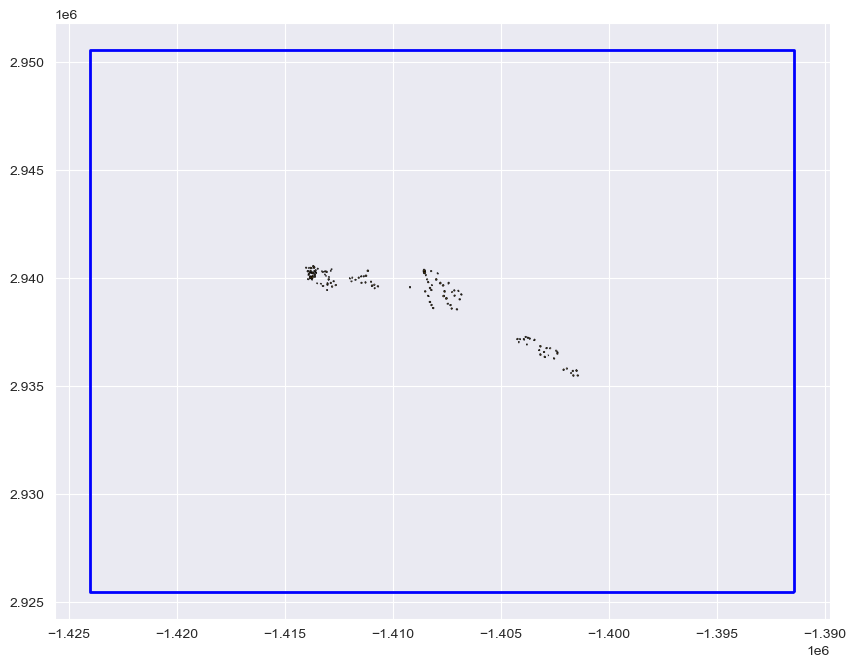

In [18]:
%matplotlib inline
# Define the box_id you want to plot
box_id_to_plot = 1  # Change this to any box_id you want to inspect

# Select the bounding box geometry
selected_box = grouped_bounds[grouped_bounds['box_id'] == box_id_to_plot]

# Select polygons that intersect with this bounding box
selected_polygons = poly_id[poly_id['box_id'] == box_id_to_plot]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the bounding box in blue
selected_box.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label="Bounding Box")

# Plot the polygons within the bounding box in orange
selected_polygons.plot(ax=ax, color='orange', edgecolor='black', alpha=0.6, label="Contained Polygons")

# Satellite Imagery based on Bounding Boxes





### Granule Querying:
>The script queries granules using the EarthAccess API to retrieve metadata and file URLs for desired data sets, without immediately downloading them.

In [1]:
# query granules and extract metadata
#

# Import necessary libraries
import earthaccess
import pandas as pd
import geopandas as gpd

# Authenticate with NASA Earthdata
earthaccess.login()  # Make sure authentication is completed

# Define collection and date range
collection = "HLSL30"  # Example collection short name
start_date = "2022-01-01"
end_date = "2022-12-31"

# Load poly_id DataFrame (ensure this file exists and has 'box_id' and 'geometry' columns)
poly_id = gpd.read_file("poly_id.geojson")  # Replace with your file path

# Summary dictionary to store collected data
collected_data = []

# Iterate through each row of poly_id
for _, row in poly_id.iterrows():
    box_id = row['box_id']
    polygon = row['geometry']  # Use the geometry column directly

    # Define bounding box with buffer
    lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat = polygon.bounds
    buffer = 0.0001  # Adjust as needed (in degrees)
    bbox = (
        max(lower_left_lon - buffer, -180),  # Ensure it doesn't exceed valid longitude
        max(lower_left_lat - buffer, -90),   # Ensure it doesn't exceed valid latitude
        min(upper_right_lon + buffer, 180),
        min(upper_right_lat + buffer, 90)
    )

    print(f"Processing box_id {box_id} with bbox: {bbox}")

    # Search granules for the current bounding box
    results = earthaccess.search_data(
        short_name=collection,
        temporal=(start_date, end_date),  # Pass start and end dates as a tuple
        bounding_box=bbox
    )

    # Limit the results if needed
    results = results[:10]  # Limit to the first 10 granules

    # Extract metadata for each granule
    for granule in results:
        granule_metadata = {
            "box_id": box_id,
            "granule_id": granule.get("id", "Missing ID"),  # Adjust key if necessary
            "title": granule.get("title", "No Title"),  # Adjust key if necessary
            "data_url": granule.get("links", {}).get("data", "No URL"),  # Adjust key if necessary
            "size": granule.get("size", "Unknown Size"),
        }
        collected_data.append(granule_metadata)

# Convert collected data to DataFrame
data_summary = pd.DataFrame(collected_data)

# Display a summary of the collected data
print("Summary of Collected Data:")
print(data_summary.head())  # Show the first few records for inspection

# Optionally save the summary to a CSV for further use
data_summary.to_csv("collected_data_summary.csv", index=False)

print("Processing completed for all bounding boxes.")










/opt/anaconda3/envs/vedu_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing box_id 3 with bbox: (-180, 2785549.434642247, -1365005.8682875708, 90)


RuntimeError: {"errors":["East must be within [-180.0] and [180.0] but was [-1365005.8682875708].","South must be within [-90.0] and [90.0] but was [2785549.434642247].","The bounding rectangle north value [90] was less than the south value [2785549.434642247]"]}

In [ ]:
### Check the results of the queried data

In [40]:
results = earthaccess.search_data(
    short_name=collection,
    temporal=(start_date, end_date),
    bounding_box=(lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat)
)

# Debug: Print the full results for this box_id
print(f"Full results for box_id {poly_id_value}:")
for result in results:
    print(result)  # Or use pprint for a more readable format

#  save results to a file for inspection
import json
with open(f"results_box_id_{poly_id_value}.json", "w") as f:
    json.dump(results, f, indent=4)


Full results for box_id 13:
Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -103.5833439, 'Latitude': 45.95676986}, {'Longitude': -103.5574919, 'Latitude': 46.94462144}, {'Longitude': -104.75621599, 'Latitude': 46.95317969}, {'Longitude': -104.99948096, 'Latitude': 46.26282656}, {'Longitude': -105.00025813, 'Latitude': 45.96555115}, {'Longitude': -103.5833439, 'Latitude': 45.95676986}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-01-05T17:41:45.585Z', 'EndingDateTime': '2022-01-05T17:42:09.472Z'}}
Size(MB): 184.75002670288086
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TEM.2022005T174145.v2.0/HLS.L30.T13TEM.2022005T174145.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TEM.

In [41]:
import logging

logging.basicConfig(filename='search_results.log', level=logging.INFO, format='%(message)s')
logging.info(f"Results for box_id {poly_id_value}: {results}")


In [42]:
for granule in results:
    print("Granule Metadata:", granule)


Granule Metadata: Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -103.5833439, 'Latitude': 45.95676986}, {'Longitude': -103.5574919, 'Latitude': 46.94462144}, {'Longitude': -104.75621599, 'Latitude': 46.95317969}, {'Longitude': -104.99948096, 'Latitude': 46.26282656}, {'Longitude': -105.00025813, 'Latitude': 45.96555115}, {'Longitude': -103.5833439, 'Latitude': 45.95676986}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-01-05T17:41:45.585Z', 'EndingDateTime': '2022-01-05T17:42:09.472Z'}}
Size(MB): 184.75002670288086
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TEM.2022005T174145.v2.0/HLS.L30.T13TEM.2022005T174145.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13TEM.2022005T17

### Data Retrieval:

>Instead of downloading files to disk, raster data is streamed directly from URLs using libraries like xarray and rioxarray.
>
-These libraries enable opening the data as multidimensional arrays with geospatial metadata, directly in memory.

### Raster Processing:

>The raster data (e.g., .tif files) are accessed using xarray.open_dataset() combined with rioxarray for geospatial operations.

>Processing tasks include slicing by band, extracting specific regions, or aggregating data over a spatial extent.

Data pull - NASA Earthaccess data request for the harmonized landsat/sentinel and sentinel/landsat. This is where we start be defining our date, plus the landsat and sentinel HLS datasets. We also define what EPSG we're in.
Starting on line 19, we search the catalog for all the Sentinel collection, with less that 30% cloud cover in our determined date range. Unfortunately because of an error in the API, we have to make the exact request separately for Landsat imagery, then combine them into one list. We then run the band crosswalk so the two lists use a common name for the bands we've requested. See the BANDS object above to see what we requested.


>	1.	Initial Request – List of Links:
When you make the first request, you’re essentially querying a catalog to see what data is available that matches your criteria (e.g., time range, geographic area, product type). This query returns a list of links or references to the datasets rather than the datasets themselves.





In [17]:
'''START_DATE = "2023-04-01" #change/update if necessary
END_DATE = "2023-10-31"
date_range = "2023-04/2023-10"
s = ["HLSS30_2.0"]
l = ["HLSL30_2.0"]
samp = grouped_bounds.loc[grouped_bounds['box_id'] == 1, 'geometry'].values[0]
HLS_Collection_id = ["HLSS30_2.0","HLSL30_2.0"]
CRS_STRING = "epsg:5070"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg() #this section is what describes the transformation needed between EPSG 4326 and 5070, it doesn't perform the transformation, just establishes the function.
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)
# Transform the AOI geometry to EPSG:4326
bbox_4326 = transform(transformer_4326.transform, samp).bounds

# Search for HLS items in collection s and l using the bounding box in EPSG:4326
stac_items = catalog.search(
    collections=s,
    bbox=bbox_4326,
    query={"eo:cloud_cover": {"lt": 30}},
    datetime=f"{START_DATE}/{END_DATE}",
)

stac_items2 = catalog.search(
    collections=l,
    bbox=bbox_4326,
    query={"eo:cloud_cover": {"lt": 30}},
    datetime=f"{START_DATE}/{END_DATE}",
)
items = list(stac_items.items())
items2 = list(stac_items2.items())

# >converts different band names from Sentinel and Landsat to a common language

#Rename bands in both item collections
for item in items:
    for original_band, bands in BAND_CROSSWALK.get(item.collection_id, {}).items():
        item.assets[bands] = item.assets.pop(original_band)

for item in items2:
    for original_band, bands in BAND_CROSSWALK.get(item.collection_id, {}).items():
        item.assets[bands] = item.assets.pop(original_band)

full = items + items2

After we make the reqest, what we get back is actually a list of links, we don't have the data yet. This next section actually requests the data into the code, odc is open data cube a similar format to our geocube we'll use shortly. We define our bands, group by day, define our resolution and our bounding box.  When we request the data, it's "lazy loaded" so basically the data sits in the cloud until we request specific parts of the data. That's useful for large datasets because we don't waste processing or data storage before we need it.

>Define Bands:
Before requesting the data, you need to specify which bands (e.g., Red, Green, Blue, Infrared) you want to work with. This helps reduce unnecessary data transfer by narrowing down the information to what’s essential for your analysis.
>Group by Time:
Grouping by day or another time period helps organize the data for time-series analysis. For example, you might want daily composites or to track changes over a specific interval.
	-	Define Resolution and Bounding Box:
	•	Resolution specifies the pixel size of the data (e.g., 10m, 30m), impacting both the level of detail and data volume.
	•	Bounding Box defines the geographic extent you’re interested in, reducing the data volume by limiting it to your area of interest.
	-	Lazy Loading:
This is a clever approach to handling large datasets. The actual data stays in the cloud until a specific part of it is needed, such as when you run computations or render a visualization. This way:
	•	You save bandwidth and processing time.
	•	You can efficiently work with massive datasets without needing to download them entirely.

In [36]:
import requests

# Define constants
HLS_COLLECTION_IDS = ["HLSS30_2.0", "HLSL30_2.0"]
CMR_URL = "https://cmr.earthdata.nasa.gov/search/granules"

# Define search parameters
def search_hls_data(collection_id, temporal_range, bounding_box, max_results=10):
    """
    Search for HLS data using NASA's CMR API.

    Args:
        collection_id (str): HLS collection ID (e.g., HLSS30_2.0 or HLSL30_2.0).
        temporal_range (str): Temporal range in the format 'YYYY-MM-DDT00:00:00Z,YYYY-MM-DDT23:59:59Z'.
        bounding_box (str): Bounding box in the format 'W,S,E,N' (e.g., '-180,-90,180,90').
        max_results (int): Maximum number of results to fetch. Default is 10.

    Returns:
        list: List of granules matching the search criteria.
    """
    # Define the request parameters
    params = {
        "collection_concept_id": collection_id,
        "temporal": temporal_range,
        "bounding_box": bounding_box,
        "page_size": max_results,
        "page_num": 1,
    }

    # Send the request to the CMR API
    response = requests.get(CMR_URL, params=params)
    response.raise_for_status()  # Raise an error if the request fails

    # Parse the response JSON
    granules = response.json()
    return granules

# Example usage
if __name__ == "__main__":
    # Set parameters for the search
    temporal_range = "2024-01-01T00:00:00Z,2024-12-31T23:59:59Z"
    bounding_box = "-180,-90,180,90"  # Global search

    # Loop through both collections and fetch results
    for collection_id in HLS_COLLECTION_IDS:
        print(f"Searching for data in collection: {collection_id}")
        try:
            results = search_hls_data(collection_id, temporal_range, bounding_box, max_results=5)
            print(f"Found {len(results)} granules for {collection_id}")
        except requests.RequestException as e:
            print(f"Error searching collection {collection_id}: {e}")

Searching for data in collection: HLSS30_2.0
Error searching collection HLSS30_2.0: 400 Client Error: Bad Request for url: https://cmr.earthdata.nasa.gov/search/granules?collection_concept_id=HLSS30_2.0&temporal=2024-01-01T00%3A00%3A00Z%2C2024-12-31T23%3A59%3A59Z&bounding_box=-180%2C-90%2C180%2C90&page_size=5&page_num=1
Searching for data in collection: HLSL30_2.0
Error searching collection HLSL30_2.0: 400 Client Error: Bad Request for url: https://cmr.earthdata.nasa.gov/search/granules?collection_concept_id=HLSL30_2.0&temporal=2024-01-01T00%3A00%3A00Z%2C2024-12-31T23%3A59%3A59Z&bounding_box=-180%2C-90%2C180%2C90&page_size=5&page_num=1


This is the definition for our cloud mask. The HLS dataset comes with a convenient Fmask quality band that defines cloud per pixel, either clear, cloud shadow, or adjacent to cloud. We define what we're going to mask out, in this case anything near on or under a cloud, and mask it out.

In [35]:
!pip install bottleneck
import bottleneck
# #Apply cloud mask
hls_mask_bitfields = [1, 2, 3]  # cloud shadow, adjacent to cloud shadow, cloud
hls_bitmask = sum(1 << field for field in hls_mask_bitfields)

fmask = hls_stack_raw.Fmask.astype("uint16")
hls_bad = fmask & hls_bitmask
ds_masked = hls_stack_raw.where(hls_bad == 0)

NameError: name 'hls_stack_raw' is not defined

This is how we set up our environment, defining all the conditions to make the data download.

This is the original post-masked dataset. It's helpful to see how many time-steps we're working with plus the size. for carter county, it looks like 63 time steps from April 1st to September 30th.

In [ ]:
ds_masked

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 27, y: 1258, x: 1411)
Coordinates:
  * y            (y) float64 10kB 2.957e+06 2.957e+06 ... 2.919e+06 2.919e+06
  * x            (x) float64 11kB -1.429e+06 -1.429e+06 ... -1.387e+06
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 216B 2023-04-06T18:30:28.564000 ... 20...
Data variables:
    red          (time, y, x) float32 192MB dask.array<chunksize=(1, 1258, 1411), meta=np.ndarray>
    green        (time, y, x) float32 192MB dask.array<chunksize=(1, 1258, 1411), meta=np.ndarray>
    blue         (time, y, x) float32 192MB dask.array<chunksize=(1, 1258, 1411), meta=np.ndarray>
    nir_narrow   (time, y, x) float32 192MB dask.array<chunksize=(1, 1258, 1411), meta=np.ndarray>
    swir_2       (time, y, x) float32 192MB dask.array<chunksize=(1, 1258, 1411), meta=np.ndarray>
    Fmask        (time, y, x) float32 192MB dask.array<chunksize=(1, 1258, 1411), meta=np.ndarray>

This builds the satellite imagery dataset and resamples it to be 8 day medians.

In [ ]:
rio_env = rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
                GDAL_HTTP_MAX_RETRY=5,
                GDAL_HTTP_RETRY_DELAY=3,
                GDAL_HTTP_RETRY_CODES="ALL")
rio_env.__enter__()


#ds = ds_masked.interpolate_na(dim="x", method="linear",limit=5).compute()
ds = ds_masked.resample(time='8D').median(dim='time', skipna=True).compute()
ds.where(ds<0,'nan',ds).compute()
ds.interpolate_na(dim="x",method="linear",limit=4).compute()
ds = ds.dropna(dim="time",how="all")
ds

This is where we're calculating our vegetation indices.

In [ ]:
ds["ndvi"] = (ds.nir_narrow - ds.red) / (ds.nir_narrow + ds.red)
ds["evi"] = 2.5 * ((ds.nir_narrow - ds.red) / (ds.nir_narrow + 6 * ds.red - 7.5 * ds.blue + 1))
ds["gndvi"] = (ds.nir_narrow - ds.green) / (ds.nir_narrow + ds.green)
ds['savi'] = ((ds.nir_narrow - ds.red) / (ds.nir_narrow + ds.red + 0.5)) * 1.5
ds["recl"] = (ds.nir_narrow / ds.red) - 1  # red-edge chlorophyll index
ds["ndwi"] = (ds.green - ds.nir_narrow) / (ds.green + ds.nir_narrow)  # normalized difference water index
ds["osavi"] = (ds.nir_narrow - ds.red) / (ds.nir_narrow + ds.red + 0.16)
ds["arvi"] = (ds.nir_narrow - (2 * ds.red) + ds.blue) / (ds.nir_narrow + (2 * ds.red) + ds.blue)
ds["sipi"] = (ds.nir_narrow - ds.blue) / (ds.nir_narrow - ds.red)  # structure-intensive pigment index
ds["gci"] = ds.nir_narrow / ds.green - 1
ds

More verification it works.

In [ ]:
%matplotlib inline
ds.gci.isel(time=12).odc.explore()'''

# Polygon to Geocube, Geocube to Xarray

This is us making the geocube out of the polygons from the merge 2023-24 shapefile. While we only call in presence, elevation, aspect slope and poly_id, we can use poly id to pull other data (columns) we may want later.

In [ ]:
#Step 6: Create the geocube for polygons in this bounding box
geocube = make_geocube(
        vector_data=poly4,
        like=ds,
        fill=0
    )
geocube

<xarray.Dataset> Size: 99MB
Dimensions:      (y: 1258, x: 1411)
Coordinates:
  * y            (y) float64 10kB 2.957e+06 2.957e+06 ... 2.919e+06 2.919e+06
  * x            (x) float64 11kB -1.429e+06 -1.429e+06 ... -1.387e+06
    spatial_ref  int64 8B 0
Data variables:
    presence     (y, x) int64 14MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    elevation    (y, x) float64 14MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    aspect       (y, x) float64 14MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    slope        (y, x) float64 14MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    poly_id      (y, x) int64 14MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    index_right  (y, x) int64 14MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    box_id       (y, x) int64 14MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

Now we're going to combine our polygon data with our geocube so its all combined into one.

In [ ]:
dsmerge = xr.merge([ds,geocube], compat='override')
dsmerge

This extracts the values that overlap with polygon data.

In [ ]:
poly4.set_geometry('geometry')
poly4_data = dsmerge.rio.clip(poly4.geometry, poly4.crs, all_touched=True)
poly_data=poly4_data.to_dataframe()
poly_data = poly_data.dropna()
poly_data

Not necessary, but just in case

In [ ]:
# poly_data["ndvi"] = (poly_data.nir_narrow - poly_data.red) / (poly_data.nir_narrow + poly_data.red)
# poly_data["evi"] = 2.5 * ((poly_data.nir_narrow - poly_data.red) / (poly_data.nir_narrow + 6 * poly_data.red - 7.5 * poly_data.blue + 1))
# poly_data["gndvi"] = (poly_data.nir_narrow - poly_data.green) / (poly_data.nir_narrow + poly_data.green)
# poly_data['savi'] = ((poly_data.nir_narrow - poly_data.red) / (poly_data.nir_narrow + poly_data.red + 0.5)) * 1.5
# poly_data["recl"] = (poly_data.nir_narrow / poly_data.red) - 1  # red-edge chlorophyll index
# poly_data["ndwi"] = (poly_data.green - poly_data.nir_narrow) / (poly_data.green + poly_data.nir_narrow)  # normalized difference water index
# poly_data["osavi"] = (poly_data.nir_narrow - poly_data.red) / (poly_data.nir_narrow + poly_data.red + 0.16)
# poly_data["arvi"] = (poly_data.nir_narrow - (2 * poly_data.red) + poly_data.blue) / (poly_data.nir_narrow + (2 * poly_data.red) + poly_data.blue)
# poly_data["sipi"] = (poly_data.nir_narrow - poly_data.blue) / (poly_data.nir_narrow - poly_data.red)  # structure-intensive pigment index
# poly_data["gci"] = poly_data.nir_narrow / poly_data.green - 1
# poly_data

In [ ]:
from matplotlib import pyplot as plt
poly_data['elevation'].plot(kind='hist', bins=20, title='nir_narrow')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Full loop with shp import

In [ ]:
# Constants
START_DATE = "2023-04-01"
END_DATE = "2023-10-31"
s = ["HLSS30_2.0"]
l = ["HLSL30_2.0"]
HLS_Collection_id = ["HLSS30_2.0", "HLSL30_2.0"]
CRS_STRING = "epsg:5070"

#transform
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg() #this section is what describes the transformation needed between EPSG 4326 and 5070, it doesn't perform the transformation, just establishes the function.
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)
# Initialize final DataFrame to store results
final_df = pd.DataFrame()

# Iterate over each bounding box in grouped_bounds
for _, bound in grouped_bounds.iterrows():
    box_id = bound['box_id']  # Extract the box_id
    geometry = bound['geometry']  # Extract the geometry for the current bounding box

    # Transform the AOI geometry to EPSG:4326 for current bounding box
    bbox_4326 = transform(transformer_4326.transform, geometry).bounds

    # Search and gather HLS items from both collections for current bounding box
    stac_items = catalog.search(collections=s, bbox=bbox_4326, query={"eo:cloud_cover": {"lt": 30}}, datetime=f"{START_DATE}/{END_DATE}")
    stac_items2 = catalog.search(collections=l, bbox=bbox_4326, query={"eo:cloud_cover": {"lt": 30}}, datetime=f"{START_DATE}/{END_DATE}")
    items = list(stac_items.items())
    items2 = list(stac_items2.items())

    # Rename bands in both item collections according to BAND_CROSSWALK
    for item in items:
        for original_band, new_band in BAND_CROSSWALK.get(item.collection_id, {}).items():
            item.assets[new_band] = item.assets.pop(original_band)

    for item in items2:
        for original_band, new_band in BAND_CROSSWALK.get(item.collection_id, {}).items():
            item.assets[new_band] = item.assets.pop(original_band)

    # Combine both collections
    full = items + items2

    # Load data using odc for current bounding box
    hls_stack_raw = odc.load(full, bands=BANDS, groupby='solar_day', chunks={}, crs=EPSG, resolution=30, bbox=bbox_4326)

    # Apply cloud mask for current bounding box
    hls_mask_bitfields = [1, 2, 3]  # Define cloud-related bitfields
    hls_bitmask = sum(1 << field for field in hls_mask_bitfields)
    fmask = hls_stack_raw.Fmask.astype("uint16")
    hls_bad = fmask & hls_bitmask
    ds_masked = hls_stack_raw.where(hls_bad == 0)

    rio_env = rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                    GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                    GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
                    GDAL_HTTP_MAX_RETRY=5,
                    GDAL_HTTP_RETRY_DELAY=3,
                    GDAL_HTTP_RETRY_CODES="ALL")
    rio_env.__enter__()

    # Resample to every 8 days and interpolate missing data for current bounding box
    ds_resampled = ds_masked.resample(time='8D').median(dim='time', skipna=True).compute()
    ds_resampled = ds_resampled.where(ds_resampled >= 0, float('nan')).compute()
    ds_resampled = ds_resampled.interpolate_na(dim="x", method="linear", limit=4).compute()
    ds_resampled = ds_resampled.dropna(dim="time", how="all")

    # **Filter polygons based on box_id for the current bounding box**
    # Assuming poly_id is a GeoDataFrame with 'box_id' as one of its columns
    poly4 = poly_id[poly_id['box_id'] == box_id]  # Filter based on the current index `i`

    # Convert polygons to geocube for current bounding box
    geocube = make_geocube(vector_data=poly4, like=ds_resampled, fill=0)

    # Merge datasets for current bounding box
    ds_merged = xr.merge([ds_resampled, geocube], compat='override')

    # Clip to polygons and extract spectral values for current bounding box
    poly4.set_geometry('geometry')
    poly4_data = ds_merged.rio.clip(poly4.geometry, poly4.crs, all_touched=True)

    # Convert to DataFrame and drop null values for current bounding box
    poly_data = poly4_data.to_dataframe().dropna()

    # Append results to final DataFrame
    final_df = pd.concat([final_df, poly_data])

# final_df contains all spectral values for each polygon across all grouped bounding boxes
print(final_df)

In [ ]:
final_df["ndvi"] = (final_df.nir_narrow - final_df.red) / (final_df.nir_narrow + final_df.red)
final_df["evi"] = 2.5 * ((final_df.nir_narrow - final_df.red) / (final_df.nir_narrow + 6 *final_df.red - 7.5 * final_df.blue + 1))
final_df["gndvi"] = (final_df.nir_narrow - final_df.green) / (final_df.nir_narrow + final_df.green)
final_df['savi'] = ((final_df.nir_narrow - final_df.red) / (final_df.nir_narrow + final_df.red + 0.5)) * 1.5
final_df["recl"] = (final_df.nir_narrow / final_df.red) - 1  # red-edge chlorophyll index
final_df["ndwi"] = (final_df.green - final_df.nir_narrow) / (final_df.green + final_df.nir_narrow)  # normalized difference water index
final_df["osavi"] = (final_df.nir_narrow - final_df.red) / (final_df.nir_narrow + final_df.red + 0.16)
final_df["arvi"] = (final_df.nir_narrow - (2 * final_df.red) + final_df.blue) / (final_df.nir_narrow + (2 * final_df.red) + final_df.blue)
final_df["sipi"] = (final_df.nir_narrow - final_df.blue) / (final_df.nir_narrow - final_df.red)  # structure-intensive pigment index
final_df["gci"] = final_df.nir_narrow / final_df.green - 1
final_df

In [ ]:
final_df=final_df.reset_index(level=["y","x","time"])

Export the data to a csv so you can skip the whole thing above.

In [ ]:
file_path = '/content/drive/MyDrive/Files/final_df.csv'
final_df.to_csv(file_path, index=False)

# Modeling

THe next sections - 5, 6, 7, and 8 all are required for the modeling calling the csv of the exported reflectance values for the polygons described above. It removes the inf and -inf values (which can happen with artifacts), drops the elevation values that are equal to 0, which happened with polygon edge values, and calculates the time values including the day of year and converts both to a datetime format.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
final_df = pd.read_csv('/content/drive/MyDrive/Files/final_df.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_df=final_df.dropna()
final_df = final_df.drop(final_df[final_df.elevation==0].index,inplace=False)

In [ ]:
final_df['time']=pd.to_datetime(final_df['time'],format="%Y-%m-%d")

In [ ]:
final_df['doy']=final_df['time'].dt.dayofyear
final_df['doy']=final_df['doy'].astype("int")

# Exploratory figures

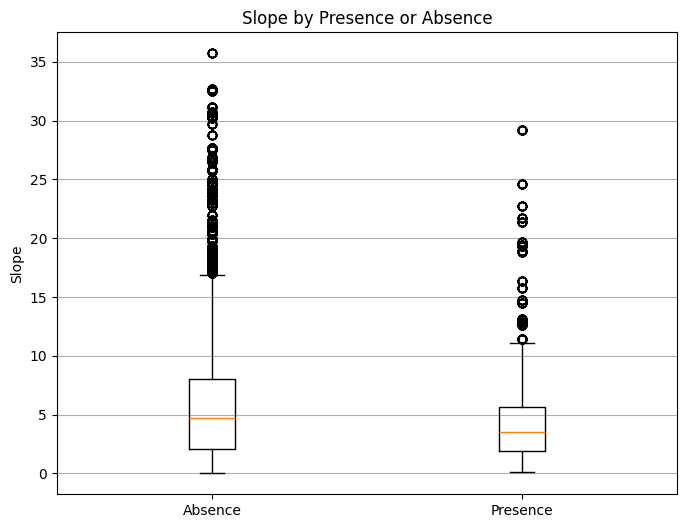

In [ ]:
%matplotlib inline
presence_0 = final_df[final_df['presence'] == 0]['slope']
presence_1 = final_df[final_df['presence'] == 1]['slope']

# Plot the NDVI over time for each presence value
plt.figure(figsize=(8, 6))
plt.boxplot([presence_0,presence_1],labels=['Absence','Presence'])

# Customize the plot
plt.title("Slope by Presence or Absence")
plt.ylabel("Slope")
plt.grid(axis='y')

# Show the plot
plt.show()

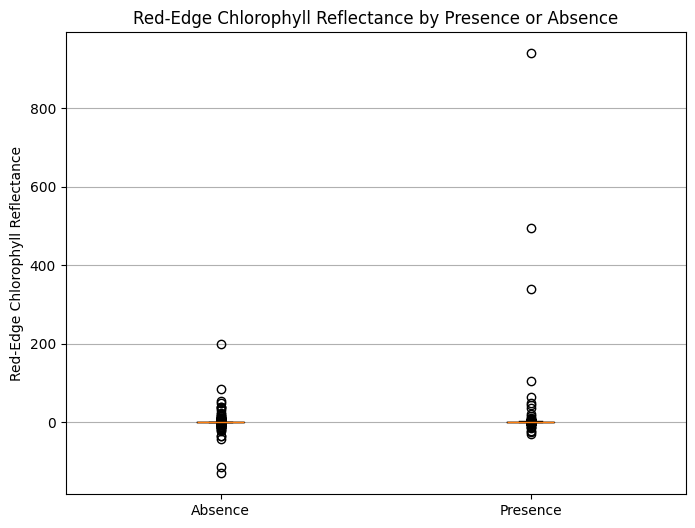

In [ ]:
%matplotlib inline
presence_0 = final_df[final_df['presence'] == 0]['evi']
presence_1 = final_df[final_df['presence'] == 1]['evi']

# Plot the NDVI over time for each presence value
plt.figure(figsize=(8, 6))
plt.boxplot([presence_0,presence_1],labels=['Absence','Presence'])

# Customize the plot
plt.title("Red-Edge Chlorophyll Reflectance by Presence or Absence")
plt.ylabel("Red-Edge Chlorophyll Reflectance")
plt.grid(axis='y')

# Show the plot
plt.show()

In [ ]:
presence_0.max()-presence_0.min()
presence_1.max()-presence_1.min()

969.202127

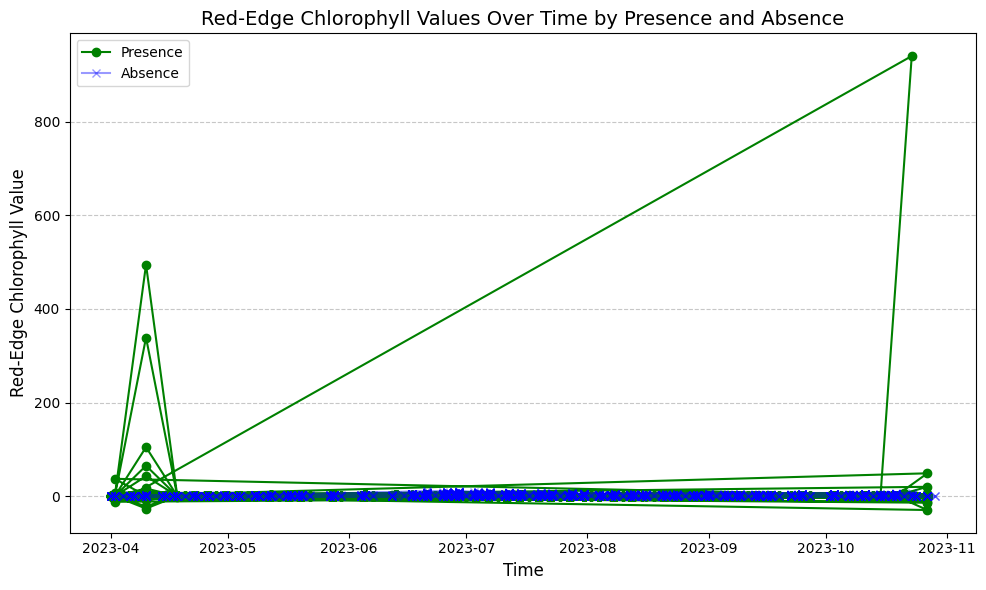

In [ ]:
#line graph
%matplotlib inline
# Separate the data by presence and absence
df_presence = final_df[final_df["presence"] == 1]
df_absence = final_df[final_df["presence"] == 0]

# Plot the recl values for presence
plt.figure(figsize=(10, 6))
plt.plot(
df_presence["time"],
df_presence["evi"],
marker="o",
color="green",
label="Presence"
)

# Plot the recl values for absence
plt.plot(
df_absence["time"],
df_absence["recl"],
marker="x",
color="blue",
label="Absence",
alpha=0.4
)

# Customize the plot
plt.title("Red-Edge Chlorophyll Values Over Time by Presence and Absence", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Red-Edge Chlorophyll Value", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn import tree,model_selection
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error,precision_recall_curve,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score

Test with and without topographical inputs

In [ ]:
#Variables that are likely correlated:"red", "green","blue","nir_narrow","swir_2"
input_vars = ["ndvi","evi","gndvi","savi","recl","ndwi","osavi","arvi","sipi","gci"]
input_vars1 = ["presence","ndvi","evi","gndvi","savi","recl","ndwi","osavi","arvi","sipi","gci"]
train, test = train_test_split(final_df,test_size=0.3,random_state=123,shuffle=True)
X = train[input_vars1]
y = train["presence"]
X_test = test[input_vars1]
y_test = test["presence"]

In [ ]:
print(X.head())

        presence      ndvi       evi     gndvi      savi      recl      ndwi  \
43697          0  0.517829  1.263279  0.531359  0.776621  2.147906 -0.531359   
75218          0  0.360793  0.792248  0.425698  0.541105  1.128876 -0.425698   
109296         0  0.245801  0.510515  0.328456  0.368658  0.651819 -0.328456   
91711          0  0.286951  0.647141  0.365486  0.430360  0.804857 -0.365486   
3050           0  0.279437  0.731072  0.350589  0.419053  0.775606 -0.350589   

           osavi      arvi      sipi       gci  doy  
43697   0.517803  0.310469  1.161487  2.267663  168  
75218   0.360775  0.155742  1.346352  1.482486  203  
109296  0.245791  0.058059  1.621752  0.978212  123  
91711   0.286937  0.097279  1.464440  1.152017  115  
3050    0.279415  0.102917  1.408341  1.079716  120  


Must run the next two lines for CV testing

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

groups = train['box_id']  # Use 'box_id' as groups

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()
gkf = GroupKFold(n_splits=5)
#print(groups)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
ts_cv = TimeSeriesSplit(n_splits=5,
                        gap=48,
                        max_train_size=10000,
                        test_size=1000)
all_splits=list(ts_cv.split(X,y))
train_0,test_0=all_splits[0]
print(ts_cv)

TimeSeriesSplit(gap=48, max_train_size=10000, n_splits=5, test_size=1000)


# Histogram Gradient Boosting Classification

In [ ]:
from sklearn.metrics import precision_score
# Define additional cross-validation techniques
time_series_cv = TimeSeriesSplit(n_splits=5, gap=48, max_train_size=10000, test_size=1000)
# Define ranges for hyperparameters
bin_sizes = [10, 50, 100, 150, 200, 255]  # Different bin sizes
iteration_counts = [10, 50, 100, 200]  # Different numbers of iterations

# Prepare to collect results
results = []
predictions = []

# Cross-validation techniques to evaluate
cv_techniques = {
    'RepeatedStratifiedKFold': RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1),
    'leaveoneout': logo,
    'TimeSeriesSplit': time_series_cv,
    'GroupKFold': gkf
}

# Loop through bin sizes, iteration counts, and CV techniques
for bins in bin_sizes:
    for max_iter in iteration_counts:
        for cv_name, cv_method in cv_techniques.items():
            print(f"Training model with bins={bins}, max_iter={max_iter}, CV={cv_name}")

            # Define the model
            model = HistGradientBoostingClassifier(
                max_bins=bins,
                max_iter=max_iter,
                class_weight='balanced',
                min_samples_leaf=60,
                learning_rate=0.05,
                max_depth=5,
                max_features=0.3,
                l2_regularization=0.001,
                random_state=3,
                early_stopping=True,
                categorical_features="from_dtype"
            )

            # Evaluate the model using cross-validation
            scores = cross_val_score(model, X[input_vars], y, groups=groups, scoring='accuracy', cv=cv_method, n_jobs=-1)

            # Fit the model
            model.fit(X[input_vars], y)

            # Predict on the test set
            y_pred = model.predict(X_test[input_vars])
            mse = mean_squared_error(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='binary')

            # Store cross-validation scores and predictions
            results.append({
                'bins': bins,
                'max_iter': max_iter,
                'cv_method': cv_name,
                'mean_cv_accuracy': np.mean(scores),
                'std_cv_accuracy': np.std(scores),
                'mse': mse,
                'accuracy': acc,
                'precision': prec,
            })

            # Group predictions by doy for plotting
            prediction_df = X_test.copy()
            prediction_df['y_pred'] = y_pred
            prediction_df['true_presence'] = y_test
            average_probabilities = prediction_df['y_pred'].mean()
            predictions.append({
                'bins': bins,
                'max_iter': max_iter,
                'cv_method': cv_name,
                'average_probabilities': average_probabilities,
            })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Plot results for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot mean accuracy
sns.barplot(data=results_df, x='cv_method', y='mean_cv_accuracy', hue='bins', ax=axes[0])
axes[0].set_title('Mean Accuracy by CV Method and Bin Size')
axes[0].set_ylabel('Mean Accuracy')
axes[0].set_xlabel('CV Method')
axes[0].legend(title='Bin Size')

# Plot mean squared error
sns.barplot(data=results_df, x='cv_method', y='mse', hue='bins', ax=axes[1])
axes[1].set_title('Mean Squared Error by CV Method and Bin Size')
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('CV Method')
axes[1].legend(title='Bin Size')

# Plot precision
sns.barplot(data=results_df, x='cv_method', y='precision', hue='bins', ax=axes[2])
axes[2].set_title('Precision by CV Method and Bin Size')
axes[2].set_ylabel('Precision')
axes[2].set_xlabel('CV Method')
axes[2].legend(title='Bin Size')

plt.tight_layout()
plt.show()

# Display predictions for the best model
best_model = results_df.sort_values(by='mean_cv_accuracy', ascending=False).iloc[0]
print("Best Model:", best_model)

# Visualize predictions for the best model
best_predictions = [
    pred['average_probabilities']
    for pred in predictions
    if pred['bins'] == best_model['bins']
    and pred['max_iter'] == best_model['max_iter']
    and pred['cv_method'] == best_model['cv_method']
][0]

Training model with bins=10, max_iter=10, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=10, max_iter=10, CV=leaveoneout
Training model with bins=10, max_iter=10, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=10, max_iter=10, CV=GroupKFold
Training model with bins=10, max_iter=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=10, max_iter=50, CV=leaveoneout
Training model with bins=10, max_iter=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=10, max_iter=50, CV=GroupKFold
Training model with bins=10, max_iter=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=10, max_iter=100, CV=leaveoneout
Training model with bins=10, max_iter=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=10, max_iter=100, CV=GroupKFold
Training model with bins=10, max_iter=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=10, max_iter=200, CV=leaveoneout
Training model with bins=10, max_iter=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=10, max_iter=200, CV=GroupKFold
Training model with bins=50, max_iter=10, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=50, max_iter=10, CV=leaveoneout
Training model with bins=50, max_iter=10, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=50, max_iter=10, CV=GroupKFold
Training model with bins=50, max_iter=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=50, max_iter=50, CV=leaveoneout
Training model with bins=50, max_iter=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=50, max_iter=50, CV=GroupKFold
Training model with bins=50, max_iter=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=50, max_iter=100, CV=leaveoneout
Training model with bins=50, max_iter=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=50, max_iter=100, CV=GroupKFold
Training model with bins=50, max_iter=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=50, max_iter=200, CV=leaveoneout
Training model with bins=50, max_iter=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=50, max_iter=200, CV=GroupKFold
Training model with bins=100, max_iter=10, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=100, max_iter=10, CV=leaveoneout
Training model with bins=100, max_iter=10, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=100, max_iter=10, CV=GroupKFold
Training model with bins=100, max_iter=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=100, max_iter=50, CV=leaveoneout
Training model with bins=100, max_iter=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=100, max_iter=50, CV=GroupKFold
Training model with bins=100, max_iter=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=100, max_iter=100, CV=leaveoneout
Training model with bins=100, max_iter=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=100, max_iter=100, CV=GroupKFold
Training model with bins=100, max_iter=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=100, max_iter=200, CV=leaveoneout
Training model with bins=100, max_iter=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=100, max_iter=200, CV=GroupKFold
Training model with bins=150, max_iter=10, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=150, max_iter=10, CV=leaveoneout
Training model with bins=150, max_iter=10, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=150, max_iter=10, CV=GroupKFold
Training model with bins=150, max_iter=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=150, max_iter=50, CV=leaveoneout
Training model with bins=150, max_iter=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=150, max_iter=50, CV=GroupKFold
Training model with bins=150, max_iter=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=150, max_iter=100, CV=leaveoneout
Training model with bins=150, max_iter=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=150, max_iter=100, CV=GroupKFold
Training model with bins=150, max_iter=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=150, max_iter=200, CV=leaveoneout
Training model with bins=150, max_iter=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=150, max_iter=200, CV=GroupKFold
Training model with bins=200, max_iter=10, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=200, max_iter=10, CV=leaveoneout
Training model with bins=200, max_iter=10, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=200, max_iter=10, CV=GroupKFold
Training model with bins=200, max_iter=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=200, max_iter=50, CV=leaveoneout
Training model with bins=200, max_iter=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=200, max_iter=50, CV=GroupKFold
Training model with bins=200, max_iter=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=200, max_iter=100, CV=leaveoneout
Training model with bins=200, max_iter=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=200, max_iter=100, CV=GroupKFold
Training model with bins=200, max_iter=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=200, max_iter=200, CV=leaveoneout
Training model with bins=200, max_iter=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=200, max_iter=200, CV=GroupKFold
Training model with bins=255, max_iter=10, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=255, max_iter=10, CV=leaveoneout
Training model with bins=255, max_iter=10, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=255, max_iter=10, CV=GroupKFold
Training model with bins=255, max_iter=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=255, max_iter=50, CV=leaveoneout
Training model with bins=255, max_iter=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=255, max_iter=50, CV=GroupKFold
Training model with bins=255, max_iter=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=255, max_iter=100, CV=leaveoneout
Training model with bins=255, max_iter=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=255, max_iter=100, CV=GroupKFold
Training model with bins=255, max_iter=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training model with bins=255, max_iter=200, CV=leaveoneout
Training model with bins=255, max_iter=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training model with bins=255, max_iter=200, CV=GroupKFold
Best Model: bins                                    150
max_iter                                200
cv_method           RepeatedStratifiedKFold
mean_cv_accuracy                   0.723905
std_cv_accuracy                    0.003921
mse                                0.272707
accuracy                           0.727293
precision                          0.704083
Name: 60, dtype: object


In [ ]:
hgbc=HistGradientBoostingClassifier(max_bins=150, max_iter=200,
class_weight='balanced',
min_samples_leaf=60,
learning_rate=0.05,
max_depth=5,
max_features=0.3,
l2_regularization=0.001,
random_state=3,
early_stopping=True).fit(X[input_vars],y)
hgbc.score(X_test[input_vars], y_test)

0.7272929322862647

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

def calculate_cv_weights(model, X, y, groups=None, cv_methods=None, scoring='accuracy'):

    if cv_methods is None:
        raise ValueError("cv_methods must be a dictionary of cross-validation techniques.")

    raw_scores = {}
    weights = {}

    # Calculate CV scores for each method
    for cv_name, cv_method in cv_methods.items():
        print(f"Evaluating using {cv_name}...")
        try:
            scores = cross_val_score(model, X, y, groups=groups, cv=cv_method, scoring=scoring, n_jobs=-1)
            raw_scores[cv_name] = np.mean(scores)  # Store the mean score
        except Exception as e:
            print(f"Error with {cv_name}: {e}")
            raw_scores[cv_name] = None

    # Normalize scores to obtain weights
    valid_scores = {k: v for k, v in raw_scores.items() if v is not None}
    if valid_scores:
        scores_array = np.array(list(valid_scores.values())).reshape(-1, 1)
        normalized_scores = MinMaxScaler().fit_transform(scores_array).flatten()

        # Assign normalized scores as weights
        for idx, (cv_name, score) in enumerate(valid_scores.items()):
            weights[cv_name] = normalized_scores[idx]

    return weights, raw_scores

In [ ]:
# Define cross-validation techniques
cv_methods = {
    'RepeatedStratifiedKFold': RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1),
    'LeaveOneOut': LeaveOneGroupOut(),
    'TimeSeriesSplit': TimeSeriesSplit(n_splits=5, gap=48, max_train_size=10000, test_size=1000),
    'GroupKFold': GroupKFold(n_splits=5),
}

# Calculate weights
weights, raw_scores = calculate_cv_weights(hgbc, X[input_vars], y, groups=groups, cv_methods=cv_methods)

predictions = hgbc.predict_proba(X[input_vars])[:, 1]
residuals = np.abs(y - predictions)  # Compute residuals

# Apply CV weights to residuals
weighted_residuals = np.zeros_like(residuals)

for cv_name, weight in weights.items():
    weighted_residuals += residuals * weight

# Calculate weights of test
groups1=test["box_id"]
weights1, raw_scores = calculate_cv_weights(hgbc, X_test[input_vars], y_test, groups=groups1, cv_methods=cv_methods)

predictions1 = hgbc.predict_proba(X_test[input_vars])[:, 1]
residuals1 = np.abs(y_test - predictions1)  # Compute residuals

# Apply CV weights to residuals
weighted_residuals1 = np.zeros_like(residuals1)

for cv_name, weights1 in weights1.items():
    weighted_residuals1 += residuals1 * weights1

Evaluating using RepeatedStratifiedKFold...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Evaluating using LeaveOneOut...
Evaluating using TimeSeriesSplit...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Evaluating using GroupKFold...
Evaluating using RepeatedStratifiedKFold...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Evaluating using LeaveOneOut...
Evaluating using TimeSeriesSplit...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Evaluating using GroupKFold...


In [ ]:
X["hgbc_pred"] = hgbc.predict_proba(X[input_vars])[:,1]
X["high_cert_hgbc"] = (X["hgbc_pred"] > 0.7).astype(int)
X["res"]=X["hgbc_pred"]-X["presence"]
X['weighted_residuals'] = weighted_residuals
X_test["hgbc_pred"] = hgbc.predict_proba(X_test[input_vars])[:,1]
X_test["weighted_residuals"] = weighted_residuals1
X_test["high_cert_hgbc"] = (X_test["hgbc_pred"] > 0.7).astype(int)
X_test["res"]=X_test["hgbc_pred"]-X_test["presence"]

<ipython-input-24-46af351ecff5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["hgbc_pred"] = hgbc.predict_proba(X[input_vars])[:,1]
<ipython-input-24-46af351ecff5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["high_cert_hgbc"] = (X["hgbc_pred"] > 0.7).astype(int)
<ipython-input-24-46af351ecff5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [ ]:
print(X['weighted_residuals'])

43697     1.434054
75218     1.044009
109296    0.645373
91711     0.717283
3050      0.187956
            ...   
175498    1.379168
171483    0.264750
68226     1.320068
96165     0.207745
63345     0.730438
Name: weighted_residuals, Length: 62988, dtype: float64


ndvi    0.147 +/- 0.003
savi    0.116 +/- 0.003
recl    0.112 +/- 0.003
osavi   0.096 +/- 0.002
gndvi   0.082 +/- 0.003
evi     0.061 +/- 0.001
ndwi    0.049 +/- 0.002
sipi    0.032 +/- 0.001
gci     0.028 +/- 0.002
arvi    0.013 +/- 0.001


{'whiskers': [<matplotlib.lines.Line2D at 0x7e19a6db6650>,
 'caps': [<matplotlib.lines.Line2D at 0x7e19a6db6d40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e19a6db47c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7e19a6db7af0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7e19a6db79a0>,
 'means': []}

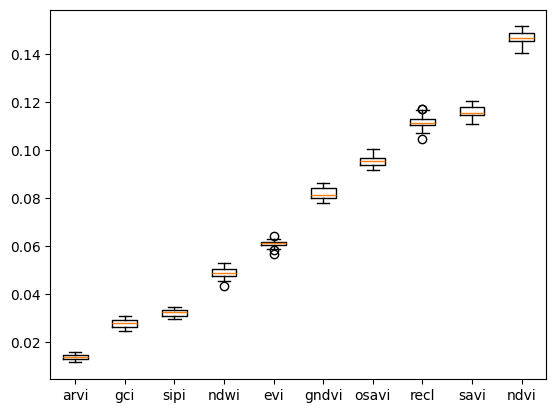

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(hgbc, X_test[input_vars], y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{input_vars[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
%matplotlib inline
plt.boxplot(r.importances[r.importances_mean.argsort()].T,
            labels=np.array(input_vars)[r.importances_mean.argsort()])

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
%matplotlib inline
disp = PartialDependenceDisplay.from_estimator(
    hgbc,
    X,
    features=[("doy","ndvi")],
    percentiles=(0,1),
    line_kw={"linewidth": 2},
    centered=True
)

In [ ]:
!pip install pickle
import pickle
# save the classifier
with open('hgbc.pkl', 'wb') as fid:
    pickle.dump(hgbc, fid)

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
from sklearn.metrics import RocCurveDisplay
hbgc_disp = RocCurveDisplay.from_estimator(hgbc,X_test, y_test)

# This is the repeat of above but with a K Nearest Neighbor Classifier




In [ ]:
logo = LeaveOneGroupOut()
gkf = GroupKFold(n_splits=5)

# Define the K-Nearest Neighbors classifier function
def nearest_neighbors(n_neighbors=3):
    return KNeighborsClassifier(n_neighbors=n_neighbors)

# Cross-validation techniques
cv_techniques = {
    'RepeatedStratifiedKFold': RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1),
    'LeaveOneOut': logo,
    'TimeSeriesSplit': ts_cv,
    'GroupKFold': gkf,
}

# Hyperparameters to test
neighbors = [3, 5, 7, 10]  # Different K values for KNN

# Prepare to collect results
results = []
predictions = []

# Loop through hyperparameters and CV techniques
for k in neighbors:
    for cv_name, cv_method in cv_techniques.items():
        print(f"Training KNN with n_neighbors={k}, CV={cv_name}")

        # Initialize the KNN model
        model = nearest_neighbors(n_neighbors=k)

        try:
            # Evaluate the model using cross-validation
            scores = cross_val_score(model, X, y, groups=groups, scoring='accuracy', cv=cv_method, n_jobs=-1)

            # Train the model on the training set
            model.fit(X, y)

            # Predict on the test set
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='binary')

            # Store cross-validation scores and predictions
            results.append({
                'k_neighbors': k,
                'cv_method': cv_name,
                'mean_cv_accuracy': np.mean(scores),
                'std_cv_accuracy': np.std(scores),
                'mse': mse,
                'accuracy': acc,
                'precision': prec,
            })

            # Group predictions by DOY for plotting
            prediction_df = X_test.copy()
            prediction_df['y_pred'] = y_pred
            prediction_df['true_presence'] = y_test
            average_probabilities = prediction_df['y_pred'].mean()
            predictions.append({
                'k_neighbors': k,
                'cv_method': cv_name,
                'average_probabilities': average_probabilities,
            })

        except Exception as e:
            print(f"Error for KNN with n_neighbors={k}, CV={cv_name}: {e}")
            continue

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

Training KNN with n_neighbors=3, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training KNN with n_neighbors=3, CV=LeaveOneOut
Training KNN with n_neighbors=3, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training KNN with n_neighbors=3, CV=GroupKFold
Training KNN with n_neighbors=5, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training KNN with n_neighbors=5, CV=LeaveOneOut
Training KNN with n_neighbors=5, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training KNN with n_neighbors=5, CV=GroupKFold
Training KNN with n_neighbors=7, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training KNN with n_neighbors=7, CV=LeaveOneOut
Training KNN with n_neighbors=7, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training KNN with n_neighbors=7, CV=GroupKFold
Training KNN with n_neighbors=10, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training KNN with n_neighbors=10, CV=LeaveOneOut
Training KNN with n_neighbors=10, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training KNN with n_neighbors=10, CV=GroupKFold


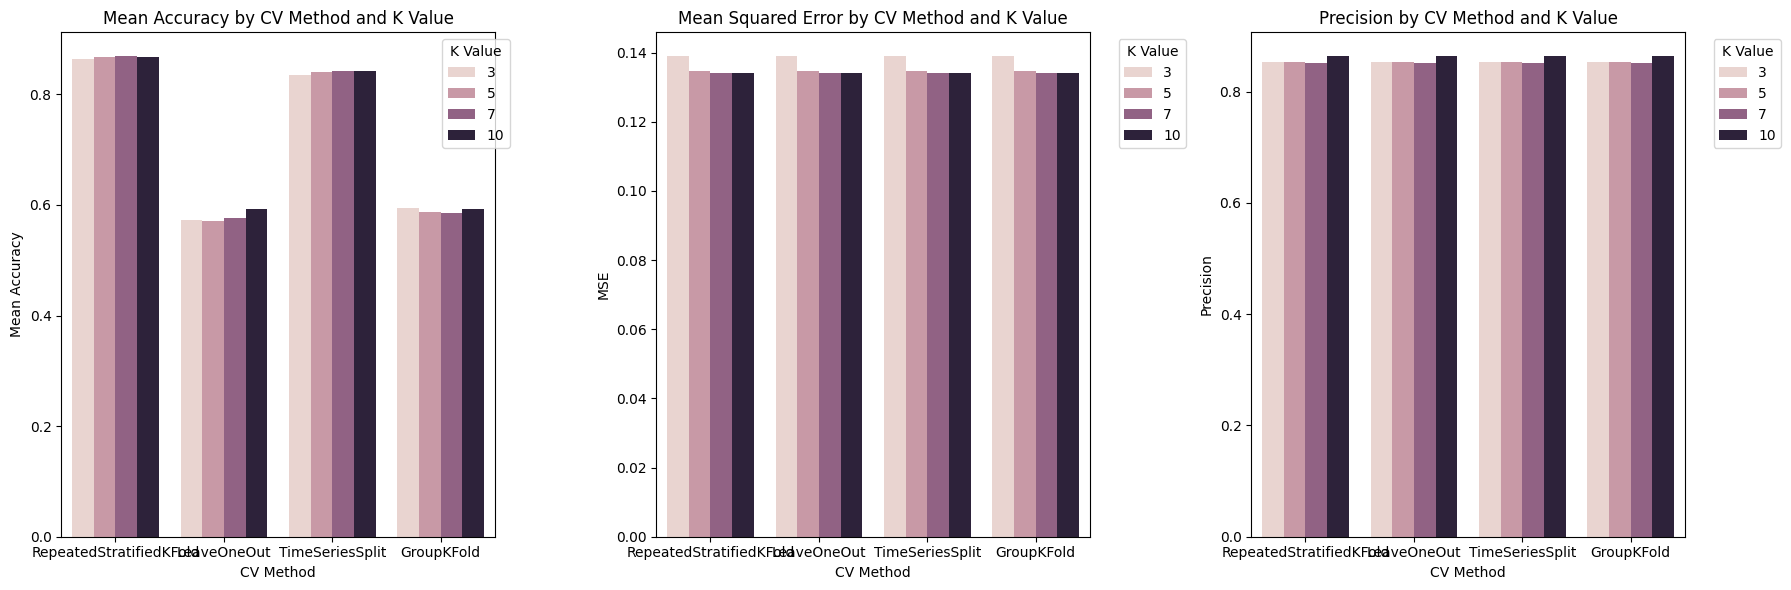

Best KNN Model: k_neighbors                               7
cv_method           RepeatedStratifiedKFold
mean_cv_accuracy                   0.868822
std_cv_accuracy                    0.003931
mse                                 0.13402
accuracy                            0.86598
precision                          0.851445
Name: 8, dtype: object


In [ ]:
%matplotlib inline
# Plot results for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot mean accuracy
sns.barplot(data=results_df, x='cv_method', y='mean_cv_accuracy', hue='k_neighbors', ax=axes[0])
axes[0].set_title('Mean Accuracy by CV Method and K Value')
axes[0].set_ylabel('Mean Accuracy')
axes[0].set_xlabel('CV Method')
axes[0].legend(title='K Value', bbox_to_anchor=(1.05, 1))

# Plot mean squared error
sns.barplot(data=results_df, x='cv_method', y='mse', hue='k_neighbors', ax=axes[1])
axes[1].set_title('Mean Squared Error by CV Method and K Value')
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('CV Method')
axes[1].legend(title='K Value', bbox_to_anchor=(1.05, 1))

# Plot precision
sns.barplot(data=results_df, x='cv_method', y='precision', hue='k_neighbors', ax=axes[2])
axes[2].set_title('Precision by CV Method and K Value')
axes[2].set_ylabel('Precision')
axes[2].set_xlabel('CV Method')
axes[2].legend(title='K Value', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Display the best model based on mean accuracy
best_model = results_df.sort_values(by='mean_cv_accuracy', ascending=False).iloc[0]
print("Best KNN Model:", best_model)

In [ ]:
random_state = 42

def nearest_neighbors(n_neighbors=3):
    return KNeighborsClassifier(n_neighbors=n_neighbors)
knn = nearest_neighbors(n_neighbors=7).fit(X, y)
knn.score(X_test, y_test)

0.8659801452066973

In [ ]:
input_vars2 = ["ndvi","evi","gndvi","savi","recl","ndwi","osavi","arvi","sipi","gci","doy", "hgbc_pred"]

doy     0.295 +/- 0.003
recl    0.116 +/- 0.002
hgbc_pred0.114 +/- 0.002
gci     0.089 +/- 0.002
evi     0.054 +/- 0.002
sipi    0.012 +/- 0.001
savi    0.006 +/- 0.001
ndvi    0.002 +/- 0.001
osavi   0.002 +/- 0.001


{'whiskers': [<matplotlib.lines.Line2D at 0x783f682fb310>,
 'caps': [<matplotlib.lines.Line2D at 0x783f682faf20>,
 'boxes': [<matplotlib.lines.Line2D at 0x783f682f8520>,
 'medians': [<matplotlib.lines.Line2D at 0x783f682fa9e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x783f682fa740>,
 'means': []}

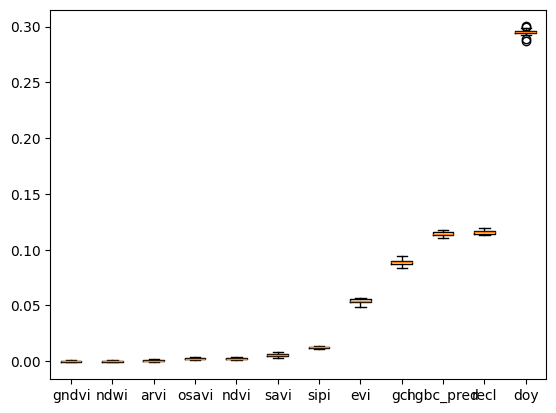

In [ ]:
# from sklearn.inspection import permutation_importance
# r = permutation_importance(knn, X_test, y_test,
#                            n_repeats=30,
#                            random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{input_vars2[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
%matplotlib inline
plt.boxplot(r.importances[r.importances_mean.argsort()].T,
            labels=np.array(input_vars2)[r.importances_mean.argsort()])

In [ ]:
X["knn_pred"] = knn.predict_proba(X)[:,1]
X_test["knn_pred"] = knn.predict_proba(X_test)[:,1]

<ipython-input-41-092963ea3ab2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["knn_pred"] = knn.predict_proba(X)[:,1]
<ipython-input-41-092963ea3ab2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["knn_pred"] = knn.predict_proba(X_test)[:,1]


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
%matplotlib inline
disp = PartialDependenceDisplay.from_estimator(
    knn,
    X,
    features=[("doy","ndvi")],
    percentiles=(0,1),
    line_kw={"linewidth": 2},
    centered=True,
    subsample=10000
)

# Random Forest Classifier + ADA Boost

Initial steps in hyperparameter tuning random forest model then using those in an ADA Boost tuning.


In [ ]:
correlation_matrix = X.corr()
print(correlation_matrix['presence'])

presence              1.000000
ndvi                  0.198014
evi                   0.022709
gndvi                 0.146135
savi                  0.198026
recl                  0.224410
ndwi                 -0.146135
osavi                 0.198018
arvi                  0.241866
sipi                 -0.015103
gci                   0.217018
doy                  -0.047955
hgbc_pred             0.722680
high_cert_hgbc        0.547133
res                  -0.789159
weighted_residuals   -0.001352
Name: presence, dtype: float64


In [ ]:
input_vars2 = ["ndvi","evi","gndvi","savi","recl","ndwi","osavi","arvi","sipi","gci", "weighted_residuals"]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GroupKFold, LeaveOneGroupOut, RepeatedStratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score


# Cross-validation techniques
ts_cv = TimeSeriesSplit(n_splits=5, gap=48, max_train_size=10000, test_size=1000)
logo = LeaveOneGroupOut()
gkf = GroupKFold(n_splits=5)

cv_techniques = {
    'RepeatedStratifiedKFold': RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1),
    'LeaveOneOut': logo,
    'TimeSeriesSplit': ts_cv,
    'GroupKFold': gkf,
}

# Define hyperparameter grids for Random Forest
max_depths = [5, 10, 20, None]  # Maximum depth of the tree
min_samples_splits = [2, 5, 10]  # Minimum number of samples required to split an internal node
n_estimators = [50, 100, 200]  # Number of trees in the forest

# Prepare to collect results
results = []
predictions = []

# Loop through hyperparameters and CV techniques
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        for n_est in n_estimators:
            for cv_name, cv_method in cv_techniques.items():
                print(f"Training RandomForest with max_depth={max_depth}, min_samples_split={min_samples_split}, "
                      f"n_estimators={n_est}, CV={cv_name}")

                # Initialize the RandomForest model
                model = RandomForestClassifier(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    n_estimators=n_est,
                    random_state=1,
                    n_jobs=-1
                )

                try:
                    # Evaluate the model using cross-validation
                    scores = cross_val_score(model, X[input_vars2], y, groups=groups, scoring='accuracy', cv=cv_method, n_jobs=-1)

                    # Train the model on the training set
                    model.fit(X[input_vars2], y)

                    # Predict on the test set
                    y_pred = model.predict(X_test[input_vars2])
                    mse = mean_squared_error(y_test, y_pred)
                    acc = accuracy_score(y_test, y_pred)
                    prec = precision_score(y_test, y_pred, average='binary')

                    # Store cross-validation scores and predictions
                    results.append({
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'n_estimators': n_est,
                        'cv_method': cv_name,
                        'mean_cv_accuracy': np.mean(scores),
                        'std_cv_accuracy': np.std(scores),
                        'mse': mse,
                        'accuracy': acc,
                        'precision': prec,
                    })

                    # Group predictions by DOY for plotting
                    prediction_df = X_test.copy()
                    prediction_df['y_pred'] = y_pred
                    prediction_df['true_presence'] = y_test
                    average_probabilities = prediction_df['y_pred'].mean()
                    predictions.append({
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'n_estimators': n_est,
                        'cv_method': cv_name,
                        'average_probabilities': average_probabilities,
                    })

                except Exception as e:
                    print(f"Error for RandomForest with max_depth={max_depth}, min_samples_split={min_samples_split}, "
                          f"n_estimators={n_est}, CV={cv_name}: {e}")
                    continue

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Display the best result
best_result = results_df.sort_values(by='mean_cv_accuracy', ascending=False).iloc[0]
print("Best Model:", best_result)

Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=100, CV=LeaveOneOut


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=200, CV=LeaveOneOut


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=2, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=5, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=5, min_samples_split=10, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=2, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=5, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=10, min_samples_split=10, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=2, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=5, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=20, min_samples_split=10, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=2, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=5, n_estimators=200, CV=GroupKFold
Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=50, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=50, CV=LeaveOneOut
Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=50, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=50, CV=GroupKFold
Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=100, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=100, CV=LeaveOneOut
Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=100, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=100, CV=GroupKFold
Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=200, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=200, CV=LeaveOneOut
Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=200, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training RandomForest with max_depth=None, min_samples_split=10, n_estimators=200, CV=GroupKFold
Best Model: max_depth                                NaN
min_samples_split                          2
n_estimators                             200
cv_method            RepeatedStratifiedKFold
mean_cv_accuracy                    0.981578
std_cv_accuracy                     0.001657
mse                                 0.023374
accuracy                            0.976626
precision                           0.982855
Name: 116, dtype: object


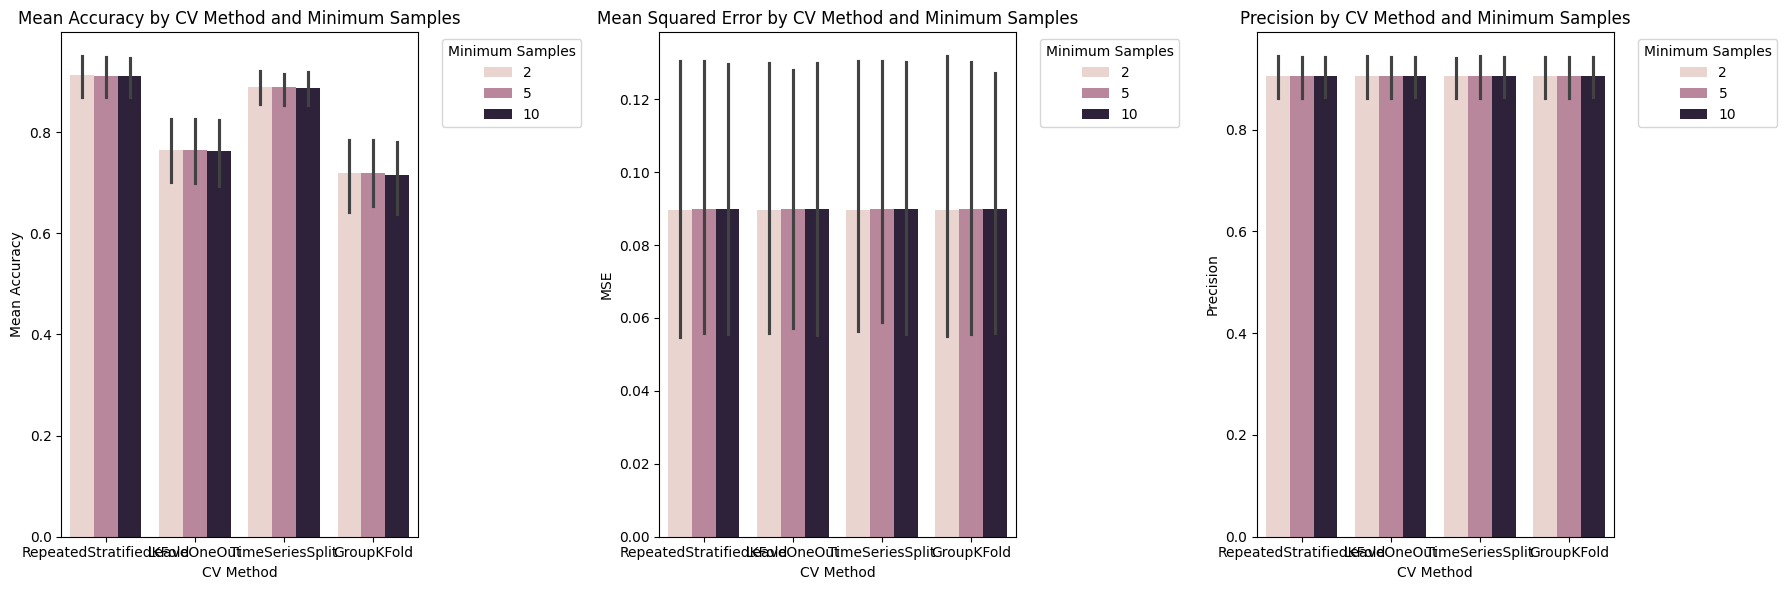

Best RF Model: max_depth                                NaN
min_samples_split                          2
n_estimators                             200
cv_method            RepeatedStratifiedKFold
mean_cv_accuracy                    0.965067
std_cv_accuracy                     0.002181
mse                                 0.038339
accuracy                            0.961661
precision                           0.966688
Name: 116, dtype: object


In [ ]:
%matplotlib inline
# Plot results for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot mean accuracy
sns.barplot(data=results_df, x='cv_method', y='mean_cv_accuracy', hue='min_samples_split', ax=axes[0])
axes[0].set_title('Mean Accuracy by CV Method and Minimum Samples')
axes[0].set_ylabel('Mean Accuracy')
axes[0].set_xlabel('CV Method')
axes[0].legend(title='Minimum Samples', bbox_to_anchor=(1.05, 1))

# Plot mean squared error
sns.barplot(data=results_df, x='cv_method', y='mse', hue='min_samples_split', ax=axes[1])
axes[1].set_title('Mean Squared Error by CV Method and Minimum Samples')
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('CV Method')
axes[1].legend(title='Minimum Samples', bbox_to_anchor=(1.05, 1))

# Plot precision
sns.barplot(data=results_df, x='cv_method', y='precision', hue='min_samples_split', ax=axes[2])
axes[2].set_title('Precision by CV Method and Minimum Samples')
axes[2].set_ylabel('Precision')
axes[2].set_xlabel('CV Method')
axes[2].legend(title='Minimum Samples', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Display the best model based on mean accuracy
best_model = results_df.sort_values(by='mean_cv_accuracy', ascending=False).iloc[0]
print("Best RF Model:", best_model)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(min_samples_split=2, n_estimators=200, random_state=1, n_jobs=-1).fit(X[input_vars2], y)
rf.score(X_test[input_vars2], y_test)

0.9766261668395317

weighted_residuals0.391 +/- 0.002
evi     0.148 +/- 0.002
sipi    0.088 +/- 0.002
savi    0.068 +/- 0.001
gndvi   0.050 +/- 0.001
ndvi    0.048 +/- 0.001
gci     0.035 +/- 0.001
ndwi    0.034 +/- 0.001
osavi   0.032 +/- 0.001
recl    0.021 +/- 0.001
arvi    0.007 +/- 0.000


{'whiskers': [<matplotlib.lines.Line2D at 0x7e181baf3b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7e181bc8a650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e181baf3250>,
 'medians': [<matplotlib.lines.Line2D at 0x7e181bb11c90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7e181bb12200>,
 'means': []}

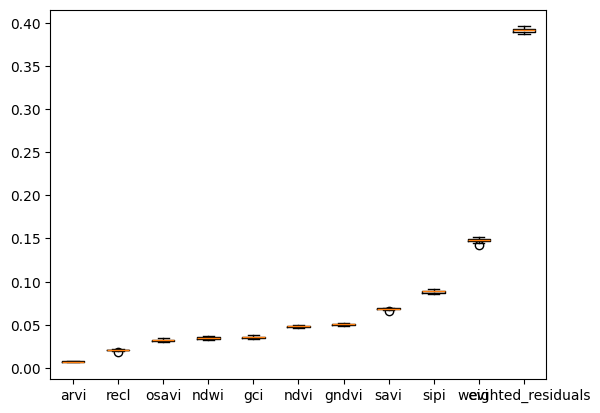

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf, X_test[input_vars2], y_test,
                           n_repeats=30,
                           random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{input_vars2[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
%matplotlib inline
plt.boxplot(r.importances[r.importances_mean.argsort()].T,
            labels=np.array(input_vars2)[r.importances_mean.argsort()])

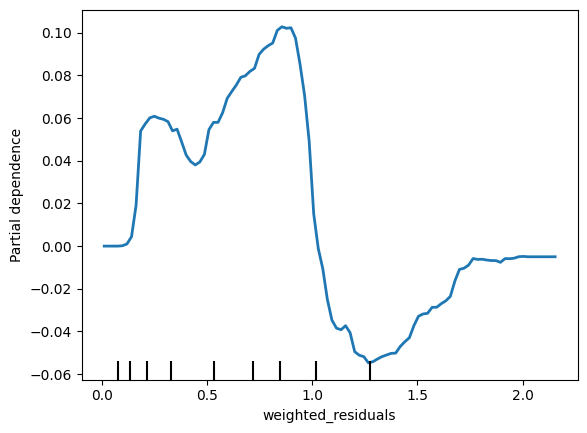

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
%matplotlib inline
disp = PartialDependenceDisplay.from_estimator(
    rf,
    X[input_vars2],
    features=[("weighted_residuals")],
    percentiles=(0,1),
    line_kw={"linewidth": 2},
    centered=True
)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GroupKFold, LeaveOneGroupOut, RepeatedStratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


# Cross-validation techniques
ts_cv = TimeSeriesSplit(n_splits=5, gap=48, max_train_size=10000, test_size=1000)
logo = LeaveOneGroupOut()
gkf = GroupKFold(n_splits=5)

cv_techniques = {
    'RepeatedStratifiedKFold': RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1),
    'LeaveOneOut': logo,
    'TimeSeriesSplit': ts_cv,
    'GroupKFold': gkf,
}

# Define hyperparameter grids for AdaBoost
n_estimators = [50, 100, 200]  # Number of estimators
learning_rates = [0.01, 0.1, 1.0]  # Learning rates

# Prepare to collect results
results = []
predictions = []
rf = RandomForestClassifier( min_samples_split=2, n_estimators=200, random_state=1, n_jobs=-1)

# Loop through hyperparameters and CV techniques
for n_est in n_estimators:
    for lr in learning_rates:
        for cv_name, cv_method in cv_techniques.items():
            print(f"Training AdaBoost with n_estimators={n_est}, learning_rate={lr}, CV={cv_name}")

            # Initialize the AdaBoost model
            model = AdaBoostClassifier(
                n_estimators=n_est,
                learning_rate=lr,
                random_state=1,
                estimator=rf
            )

            try:
                # Evaluate the model using cross-validation
                scores = cross_val_score(model, X[input_vars2], y, groups=groups, scoring='accuracy', cv=cv_method, n_jobs=-1)

                # Train the model on the training set
                model.fit(X[input_vars2], y)

                # Predict on the test set
                y_pred = model.predict(X_test[input_vars2])
                mse = mean_squared_error(y_test, y_pred)
                acc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred, average='binary')

                # Store cross-validation scores and predictions
                results.append({
                    'n_estimators': n_est,
                    'learning_rate': lr,
                    'cv_method': cv_name,
                    'mean_cv_accuracy': np.mean(scores),
                    'std_cv_accuracy': np.std(scores),
                    'mse': mse,
                    'accuracy': acc,
                    'precision': prec,
                })

                # Group predictions by DOY for plotting
                prediction_df = X_test.copy()
                prediction_df['y_pred'] = y_pred
                prediction_df['true_presence'] = y_test
                average_probabilities = prediction_df['y_pred'].mean()
                predictions.append({
                    'n_estimators': n_est,
                    'learning_rate': lr,
                    'cv_method': cv_name,
                    'average_probabilities': average_probabilities,
                })

            except Exception as e:
                print(f"Error for AdaBoost with n_estimators={n_est}, learning_rate={lr}, CV={cv_name}: {e}")
                continue

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Display the best result
best_result = results_df.sort_values(by='mean_cv_accuracy', ascending=False).iloc[0]
print("Best Model:", best_result)

Training AdaBoost with n_estimators=50, learning_rate=0.01, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training AdaBoost with n_estimators=50, learning_rate=0.01, CV=LeaveOneOut
Training AdaBoost with n_estimators=50, learning_rate=0.01, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training AdaBoost with n_estimators=50, learning_rate=0.01, CV=GroupKFold
Training AdaBoost with n_estimators=50, learning_rate=0.1, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training AdaBoost with n_estimators=50, learning_rate=0.1, CV=LeaveOneOut
Training AdaBoost with n_estimators=50, learning_rate=0.1, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training AdaBoost with n_estimators=50, learning_rate=0.1, CV=GroupKFold
Training AdaBoost with n_estimators=50, learning_rate=1.0, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training AdaBoost with n_estimators=50, learning_rate=1.0, CV=LeaveOneOut
Training AdaBoost with n_estimators=50, learning_rate=1.0, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training AdaBoost with n_estimators=50, learning_rate=1.0, CV=GroupKFold
Training AdaBoost with n_estimators=100, learning_rate=0.01, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training AdaBoost with n_estimators=100, learning_rate=0.01, CV=LeaveOneOut
Training AdaBoost with n_estimators=100, learning_rate=0.01, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training AdaBoost with n_estimators=100, learning_rate=0.01, CV=GroupKFold
Training AdaBoost with n_estimators=100, learning_rate=0.1, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training AdaBoost with n_estimators=100, learning_rate=0.1, CV=LeaveOneOut
Training AdaBoost with n_estimators=100, learning_rate=0.1, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training AdaBoost with n_estimators=100, learning_rate=0.1, CV=GroupKFold
Training AdaBoost with n_estimators=100, learning_rate=1.0, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training AdaBoost with n_estimators=100, learning_rate=1.0, CV=LeaveOneOut
Training AdaBoost with n_estimators=100, learning_rate=1.0, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training AdaBoost with n_estimators=100, learning_rate=1.0, CV=GroupKFold
Training AdaBoost with n_estimators=200, learning_rate=0.01, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training AdaBoost with n_estimators=200, learning_rate=0.01, CV=LeaveOneOut
Training AdaBoost with n_estimators=200, learning_rate=0.01, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training AdaBoost with n_estimators=200, learning_rate=0.01, CV=GroupKFold
Training AdaBoost with n_estimators=200, learning_rate=0.1, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training AdaBoost with n_estimators=200, learning_rate=0.1, CV=LeaveOneOut
Training AdaBoost with n_estimators=200, learning_rate=0.1, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training AdaBoost with n_estimators=200, learning_rate=0.1, CV=GroupKFold
Training AdaBoost with n_estimators=200, learning_rate=1.0, CV=RepeatedStratifiedKFold


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training AdaBoost with n_estimators=200, learning_rate=1.0, CV=LeaveOneOut
Training AdaBoost with n_estimators=200, learning_rate=1.0, CV=TimeSeriesSplit


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


Training AdaBoost with n_estimators=200, learning_rate=1.0, CV=GroupKFold
Best Model: n_estimators                             50
learning_rate                          0.01
cv_method           RepeatedStratifiedKFold
mean_cv_accuracy                   0.981197
std_cv_accuracy                    0.001548
mse                                0.022818
accuracy                           0.977182
precision                          0.982873
Name: 0, dtype: object


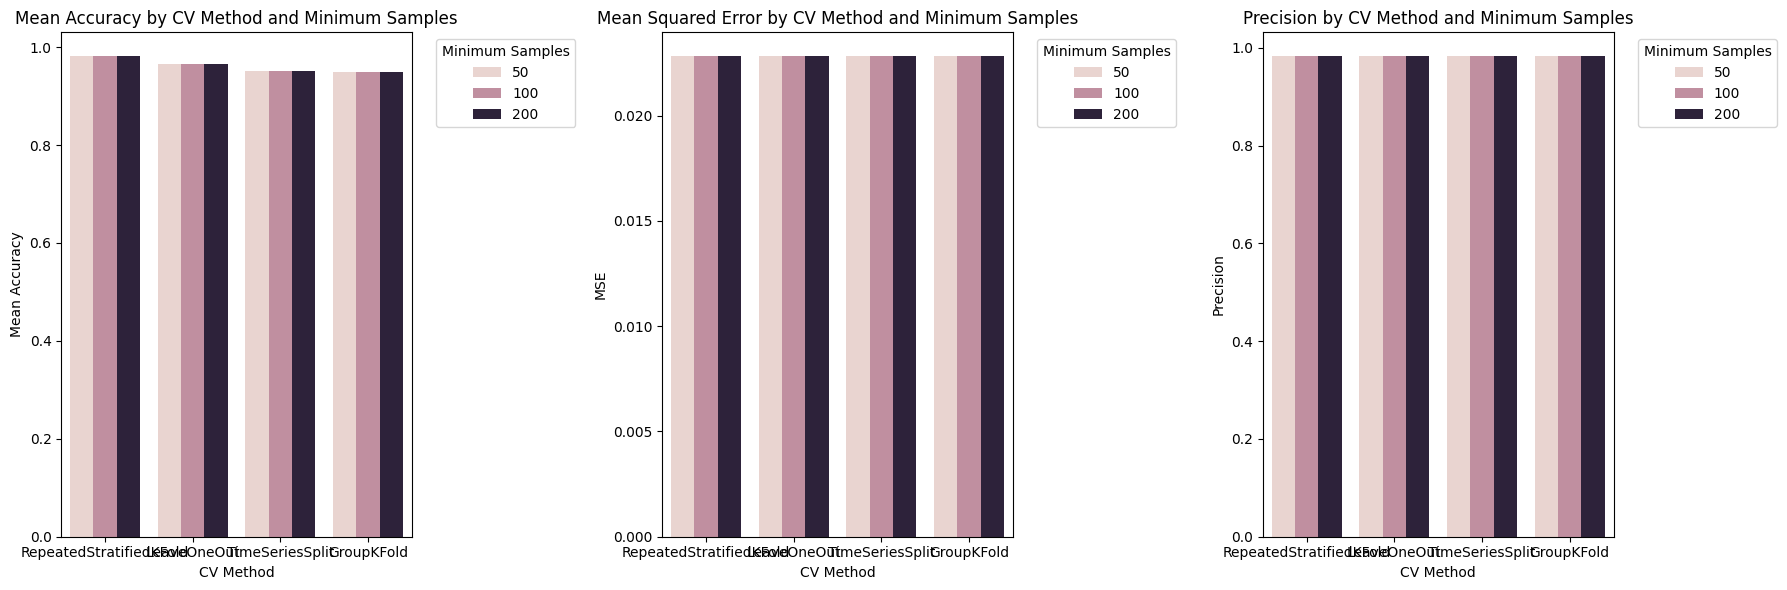

Best Ada Hyperparameters: n_estimators                             50
learning_rate                          0.01
cv_method           RepeatedStratifiedKFold
mean_cv_accuracy                   0.981197
std_cv_accuracy                    0.001548
mse                                0.022818
accuracy                           0.977182
precision                          0.982873
Name: 0, dtype: object


In [ ]:
%matplotlib inline
# Plot results for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot mean accuracy
sns.barplot(data=results_df, x='cv_method', y='mean_cv_accuracy', hue='n_estimators', ax=axes[0])
axes[0].set_title('Mean Accuracy by CV Method and Minimum Samples')
axes[0].set_ylabel('Mean Accuracy')
axes[0].set_xlabel('CV Method')
axes[0].legend(title='Minimum Samples', bbox_to_anchor=(1.05, 1))

# Plot mean squared error
sns.barplot(data=results_df, x='cv_method', y='mse', hue='n_estimators', ax=axes[1])
axes[1].set_title('Mean Squared Error by CV Method and Minimum Samples')
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('CV Method')
axes[1].legend(title='Minimum Samples', bbox_to_anchor=(1.05, 1))

# Plot precision
sns.barplot(data=results_df, x='cv_method', y='precision', hue='n_estimators', ax=axes[2])
axes[2].set_title('Precision by CV Method and Minimum Samples')
axes[2].set_ylabel('Precision')
axes[2].set_xlabel('CV Method')
axes[2].legend(title='Minimum Samples', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Display the best model based on mean accuracy
best_model = results_df.sort_values(by='mean_cv_accuracy', ascending=False).iloc[0]
print("Best Ada Hyperparameters:", best_model)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
rf = RandomForestClassifier( min_samples_split=2, n_estimators=200, random_state=1, n_jobs=-1)

ada = AdaBoostClassifier(n_estimators=50, learning_rate = 0.01, random_state=42, estimator= rf).fit(X[input_vars2], y)
ada.score(X_test[input_vars2], y_test)

0.9767002518891688

weighted_residuals0.391 +/- 0.002
evi     0.170 +/- 0.002
sipi    0.070 +/- 0.001
savi    0.042 +/- 0.001
ndwi    0.038 +/- 0.001
osavi   0.036 +/- 0.001
gndvi   0.033 +/- 0.001
gci     0.030 +/- 0.001
recl    0.030 +/- 0.001
ndvi    0.026 +/- 0.001
arvi    0.006 +/- 0.000


{'whiskers': [<matplotlib.lines.Line2D at 0x7e15bc6b63e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e15bc6b63b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e15bc6b4b20>,
 'medians': [<matplotlib.lines.Line2D at 0x7e15bc526e30>,
 'fliers': [<matplotlib.lines.Line2D at 0x7e15bc527a60>,
 'means': []}

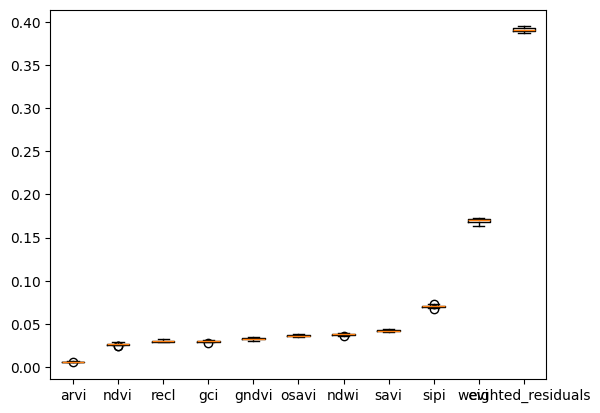

In [ ]:
# from sklearn.inspection import permutation_importance
r = permutation_importance(ada, X_test[input_vars2], y_test,
                           n_repeats=30,
                           random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{input_vars2[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
%matplotlib inline
plt.boxplot(r.importances[r.importances_mean.argsort()].T,
            labels=np.array(input_vars2)[r.importances_mean.argsort()])

In [ ]:
# Define cross-validation techniques
cv_methods = {
    'RepeatedStratifiedKFold': RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1),
    'LeaveOneOut': LeaveOneGroupOut(),
    'TimeSeriesSplit': TimeSeriesSplit(n_splits=5, gap=48, max_train_size=10000, test_size=1000),
    'GroupKFold': GroupKFold(n_splits=5),
}

# Calculate weights
weights, raw_scores = calculate_cv_weights(ada, X[input_vars2], y, groups=groups, cv_methods=cv_methods)

predictions = ada.predict_proba(X[input_vars2])[:, 1]
residuals = np.abs(y - predictions)  # Compute residuals

# Apply CV weights to residuals
weighted_residuals = np.zeros_like(residuals)

for cv_name, weight in weights.items():
    weighted_residuals += residuals * weight

# Calculate weights of test
groups1=test["box_id"]
weights1, raw_scores = calculate_cv_weights(ada, X_test[input_vars2], y_test, groups=groups1, cv_methods=cv_methods)

predictions1 = ada.predict_proba(X_test[input_vars2])[:, 1]
residuals1 = np.abs(y_test - predictions1)  # Compute residuals

# Apply CV weights to residuals
weighted_residuals1 = np.zeros_like(residuals1)

for cv_name, weights1 in weights1.items():
    weighted_residuals1 += residuals1 * weights1

Evaluating using RepeatedStratifiedKFold...
Evaluating using LeaveOneOut...
Evaluating using TimeSeriesSplit...
Evaluating using GroupKFold...
Evaluating using RepeatedStratifiedKFold...
Evaluating using LeaveOneOut...
Evaluating using TimeSeriesSplit...
Evaluating using GroupKFold...


In [ ]:
X["ada_pred"] = ada.predict_proba(X[input_vars2])[:,1]
X["high_cert_ada"] = (X["ada_pred"] > 0.7).astype(int)
X["res_ada"]=X["ada_pred"]-X["presence"]
X['weighted_residuals_ada'] = weighted_residuals
X_test["ada_pred"] = ada.predict_proba(X_test[input_vars2])[:,1]
X_test["weighted_residuals_ada"] = weighted_residuals1
X_test["high_cert_ada"] = (X_test["ada_pred"] > 0.7).astype(int)
X_test["res_ada"]=X_test["ada_pred"]-X_test["presence"]

# Bring in test/predictive plots
BisonRange.shp and Crow_Test_Data.shp

In [ ]:
# Constants and Paths (fill these in as needed)
CRS_STRING = "epsg:5070"
# Load and reproject the shapefile to the target CRS
Crow_td = gp.read_file('/content/drive/MyDrive/Files/Crow_Test_Data.shp')  # Replace with the path to your shapefile
#Crow_td = gp.read_file('/content/drive/MyDrive/Files/BisonRange.shp')  # Replace with the path to your shapefile
CRS_STRING = "epsg:5070"
crow = Crow_td.to_crs(CRS_STRING)
crow=box(crow.total_bounds[0],crow.total_bounds[1],crow.total_bounds[2],crow.total_bounds[3])
START_DATE = "2023-09-01" #change/update if necessary
END_DATE = "2023-09-30"
s = ["HLSS30_2.0"]
l = ["HLSL30_2.0"]

HLS_Collection_id = ["HLSS30_2.0","HLSL30_2.0"]
CRS_STRING = "epsg:5070"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg() #this section is what describes the transformation needed between EPSG 4326 and 5070, it doesn't perform the transformation, just establishes the function.
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)
# Transform the AOI geometry to EPSG:4326
bbox = transform(transformer_4326.transform, crow).bounds

# # Search for HLS items in collection s and l using the bounding box in EPSG:4326
stac_items = catalog.search(
    collections=HLS_Collection_id,
    bbox=bbox,
    query={"eo:cloud_cover": {"lt": 30}},
    datetime=f"{START_DATE}/{END_DATE}",
).item_collection()


# stac_items2 = catalog.search(
#     collections=l,
#     bbox=bbox,
#     query={"eo:cloud_cover": {"lt": 30}},
#     datetime=f"{START_DATE}/{END_DATE}",
# )
# items = list(stac_items.items())
# items2 = list(stac_items2.items())

#Rename bands in both item collections
for item in stac_items:
    for original_band, new_band in BAND_CROSSWALK.get(item.collection_id).items():
        item.assets[new_band] = item.assets.pop(original_band)

# for item in items2:
#     for original_band, bands in BAND_CROSSWALK.get(item.collection_id, {}).items():
#         item.assets[bands] = item.assets.pop(original_band)

#full = items + items2
hls_stack_raw = odc.load(
    stac_items,
    bands=BANDS,
    groupby='solar_day',
    chunks={},
    crs=EPSG,
    resolution=30,
    bbox=bbox
)

In [ ]:
rio_env = rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
                GDAL_HTTP_MAX_RETRY=5,
                GDAL_HTTP_RETRY_DELAY=3,
                GDAL_HTTP_RETRY_CODES="ALL")
rio_env.__enter__()
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')

In [ ]:
# !pip install bottleneck
# import bottleneck
# #Apply cloud mask
hls_mask_bitfields = [1, 2, 3]  # cloud shadow, adjacent to cloud shadow, cloud
hls_bitmask = sum(1 << field for field in hls_mask_bitfields)

fmask = hls_stack_raw.Fmask.astype("uint16")
hls_bad = fmask & hls_bitmask
ds_masked = hls_stack_raw.where(hls_bad == 0)
rio_env = rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
                GDAL_HTTP_MAX_RETRY=5,
                GDAL_HTTP_RETRY_DELAY=3,
                GDAL_HTTP_RETRY_CODES="ALL")
rio_env.__enter__()


#ds = ds_masked.interpolate_na(dim="x", method="linear",limit=5).compute()
# ds = ds_masked.resample(time='1W').median(dim='time', skipna=True).compute()

In [ ]:
ds=ds_masked

Calculate the vegetation indices used in the predictive modeling for the test or predictive plot.

In [ ]:
ds["ndvi"] = (ds.nir_narrow - ds.red) / (ds.nir_narrow + ds.red)
ds["evi"] = 2.5 * ((ds.nir_narrow - ds.red) / (ds.nir_narrow + 6 * ds.red - 7.5 * ds.blue + 1))
ds["gndvi"] = (ds.nir_narrow - ds.green) / (ds.nir_narrow + ds.green)
ds['savi'] = ((ds.nir_narrow - ds.red) / (ds.nir_narrow + ds.red + 0.5)) * 1.5
ds["recl"] = (ds.nir_narrow / ds.red) - 1  # red-edge chlorophyll index
ds["ndwi"] = (ds.green - ds.nir_narrow) / (ds.green + ds.nir_narrow)  # normalized difference water index
ds["osavi"] = (ds.nir_narrow - ds.red) / (ds.nir_narrow + ds.red + 0.16)
ds["arvi"] = (ds.nir_narrow - (2 * ds.red) + ds.blue) / (ds.nir_narrow + (2 * ds.red) + ds.blue)
ds["sipi"] = (ds.nir_narrow - ds.blue) / (ds.nir_narrow - ds.red)  # structure-intensive pigment index
ds["gci"] = ds.nir_narrow / ds.green - 1
ds['doy']=ds.time.dt.dayofyear
ds

<xarray.Dataset> Size: 29GB
Dimensions:      (time: 18, y: 4271, x: 5807)
Coordinates:
  * y            (y) float64 34kB 2.604e+06 2.604e+06 ... 2.476e+06 2.476e+06
  * x            (x) float64 46kB -1.013e+06 -1.013e+06 ... -8.386e+05
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 144B 2023-09-02T18:00:24.894000 ... 20...
Data variables: (12/17)
    red          (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    green        (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    blue         (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    nir_narrow   (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    swir_2       (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    Fmask        (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    ...           ...
    ndwi         (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    osavi        (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    arvi         (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    sipi         (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    gci          (time, y, x) float32 2GB dask.array<chunksize=(1, 4271, 5807), meta=np.ndarray>
    doy          (time) int64 144B 245 249 253 254 255 ... 268 269 270 271 272

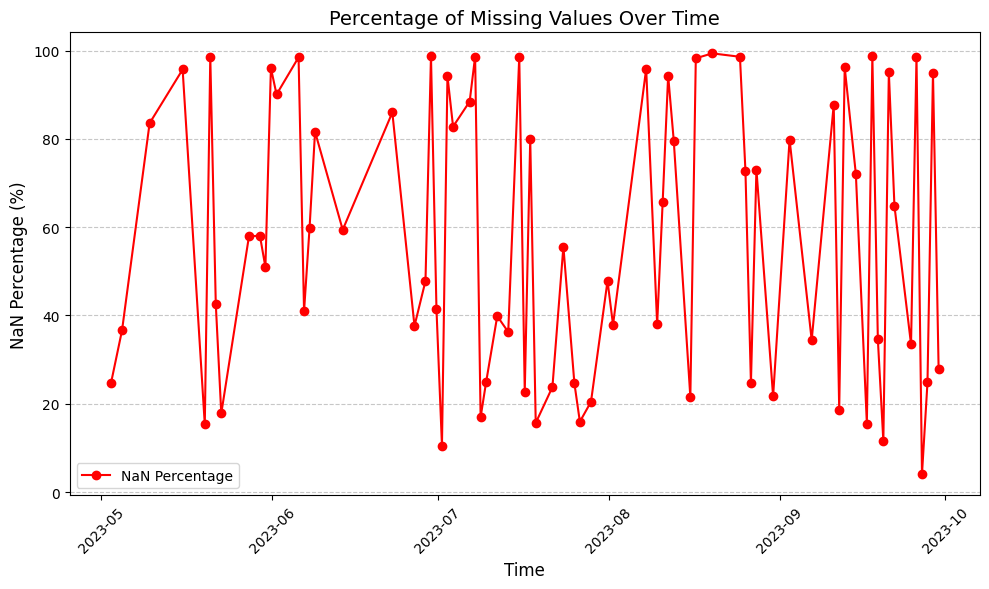

In [ ]:
%matplotlib inline
# Prepare to store percentages of missing values for each timestep
time_steps = []
nan_percentages = []

# Loop through each timestep
for t in ds.time:
    # Select the data for the current timestep
    red_data = ds['red'].sel(time=t)

    # Calculate the number of missing values
    nan_count = red_data.isnull().values.sum()

    # Calculate the total number of values
    total_values = len(ds["x"]) * len(ds["y"])  # Total grid cells (x * y)

    # Calculate the percentage of missing values
    nan_percentage = (nan_count / total_values) * 100

    # Store the results
    time_steps.append(t.values)
    nan_percentages.append(nan_percentage)

# Convert to a pandas DataFrame (optional, for better handling)
import pandas as pd
nan_df = pd.DataFrame({"time": time_steps, "nan_percentage": nan_percentages})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(nan_df["time"], nan_df["nan_percentage"], marker="o", color="red", label="NaN Percentage")
plt.title("Percentage of Missing Values Over Time", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("NaN Percentage (%)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline
ds.ndvi.odc.explore()

/usr/local/lib/python3.10/dist-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/_task_spec.py:740: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/usr/local/lib/python3.10/dist-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [ ]:
###Crow Filtering
ds = ds.isel(time=14)
# ds = ds.chunk({"time":len(ds.time)})
# dsi = ds.interpolate_na(dim="time",method="nearest").compute()


In [ ]:
%matplotlib inline
# Calculate the number of valid (non-NaN) values for each timestep
valid_counts = ds['red'].isnull()
valid_counts = valid_counts.values.sum()
# Calculate the total number of values per timestep
total_values = len(ds["x"]) * len(ds["y"])  # Total grid cells (x * y)

# Calculate the number of NaNs by subtracting valid counts from total counts
nan_per = valid_counts/total_values
print(nan_per*100)

4.054339507494185


/usr/local/lib/python3.10/dist-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


You have to conver the dataset to a dataframe first.

In [ ]:
ds=ds.median(dim='time')
ds

<xarray.Dataset> Size: 15MB
Dimensions:      (y: 491, x: 463)
Coordinates:
  * y            (y) float64 4kB 2.844e+06 2.844e+06 ... 2.829e+06 2.829e+06
  * x            (x) float64 4kB -1.384e+06 -1.384e+06 ... -1.37e+06 -1.37e+06
    spatial_ref  int32 4B 5070
Data variables: (12/17)
    red          (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    green        (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    blue         (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    nir_narrow   (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    swir_2       (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    Fmask        (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    ...           ...
    ndwi         (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    osavi        (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    arvi         (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    sipi         (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    gci          (y, x) float32 909kB dask.array<chunksize=(491, 463), meta=np.ndarray>
    doy          float64 8B 255.0

In [ ]:
from sklearn import preprocessing
ds_ts = ds.to_dataframe()
np.isfinite(ds_ts).sum()
ds_ts.replace([np.inf, -np.inf], np.nan, inplace=True)
ds_ts.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/usr/local/lib/python3.10/dist-packages/dask/array/chunk.p

In [ ]:
ds_ts

red  green   blue  nir_narrow  \
time                    y         x                                             
2023-09-08 18:51:11.533 2843745.0 -1383735.0  288.0  708.0  369.0      5751.0   
                                  -1383705.0  286.0  702.0  364.0      5607.0   
                                  -1383675.0  275.0  691.0  347.0      5303.0   
                                  -1383645.0  263.0  674.0  327.0      5365.0   
                                  -1383615.0  286.0  688.0  347.0      5230.0   
...                                             ...    ...    ...         ...   
2023-09-15 18:41:14.714 2829045.0 -1369995.0  295.0  367.0  191.0      2030.0   
                                  -1369965.0  404.0  488.0  256.0      2225.0   
                                  -1369935.0  298.0  384.0  192.0      2109.0   
                                  -1369905.0  298.0  384.0  192.0      2109.0   
                                  -1369875.0  315.0  465.0  220.0      2208.0   

                                              swir_2  Fmask  spatial_ref  \
time                    y         x                                        
2023-09-08 18:51:11.533 2843745.0 -1383735.0   868.0   64.0         5070   
                                  -1383705.0   872.0   64.0         5070   
                                  -1383675.0   856.0   64.0         5070   
                                  -1383645.0   862.0   64.0         5070   
                                  -1383615.0   853.0   64.0         5070   
...                                              ...    ...          ...   
2023-09-15 18:41:14.714 2829045.0 -1369995.0   678.0   64.0         5070   
                                  -1369965.0   768.0   64.0         5070   
                                  -1369935.0   645.0   64.0         5070   
                                  -1369905.0   645.0   64.0         5070   
                                  -1369875.0   588.0   64.0         5070   

                                                  ndvi       evi     gndvi  \
time                    y         x                                          
2023-09-08 18:51:11.533 2843745.0 -1383735.0  0.904620  2.898143  0.780771   
                                  -1383705.0  0.902936  2.895625  0.777461   
                                  -1383675.0  0.901398  2.888659  0.769436   
                                  -1383645.0  0.906539  2.839808  0.776784   
                                  -1383615.0  0.896302  2.844976  0.767489   
...                                                ...       ...       ...   
2023-09-15 18:41:14.714 2829045.0 -1369995.0  0.746237  1.831328  0.693784   
                                  -1369965.0  0.692659  1.667582  0.640251   
                                  -1369935.0  0.752389  1.841945  0.691937   
                                  -1369905.0  0.752389  1.841945  0.691937   
                                  -1369875.0  0.750297  1.932421  0.652076   

                                                  savi       recl      ndwi  \
time                    y         x                                           
2023-09-08 18:51:11.533 2843745.0 -1383735.0  1.356818  18.968750 -0.780771   
                                  -1383705.0  1.354289  18.604895 -0.777461   
                                  -1383675.0  1.351976  18.283636 -0.769436   
                                  -1383645.0  1.359687  19.399240 -0.776784   
                                  -1383615.0  1.344331  17.286713 -0.767489   
...                                                ...        ...       ...   
2023-09-15 18:41:14.714 2829045.0 -1369995.0  1.119114   5.881356 -0.693784   
                                  -1369965.0  1.038791   4.507426 -0.640251   
                                  -1369935.0  1.128349   6.077181 -0.691937   
                                  -1369905.0  1.128349   6.077181 -0.691937   
                                  -1369875

Since we convert it to a pandas dataframe, we have to retain the spatial component of it. This starts by storing the dimension length of x and y.

In [ ]:
leny=len(ds.y)
lenx=len(ds.x)
print(lenx,leny)

5807 4271


Here's where we actually predict on the surface. I haven't figured out how to predict in a loop on time series so handle just single time dimension predictions.

In [ ]:
input_vars2 = ["ndvi","evi","gndvi","savi","recl","ndwi","osavi","arvi","sipi","gci","doy", "hgbc_pred"]
input_vars3 = ["ndvi","evi","gndvi","savi","recl","ndwi","osavi","arvi","sipi","gci","doy", "hgbc_pred","rf_pred"]

In [ ]:
hgbc_crow_pred = hgbc.predict_proba(ds_ts[input_vars1])
ds_ts['hgbc_pred'] = hgbc_crow_pred[:, 1]
rf_crow_pred = rf.predict_proba(ds_ts[input_vars2])
ds_ts['rf_pred'] = rf_crow_pred[:, 1]
ada_crow_pred = ada.predict_proba(ds_ts[input_vars3])

In [ ]:
# hgbc_crow_pos = hgbc_crow_pred[:, 1]
# knn_crow_pos = knn_crow_pred
# rf_crow_pos = rf_crow_pred[:, 1]
ada_crow_pos = ada_crow_pred[:, 1]

In [ ]:
# hgbc_crow_pos.shape = (hgbc_crow_pos.size//lenx,lenx)
# hgbc_crow_pos = xr.DataArray(data=hgbc_crow_pos,coords={'y':ds.y,'x':ds.x},name="hgbc presence")
# knn_crow_pos.shape = (knn_crow_pos.size//lenx,lenx)
# knn_crow_pos = xr.DataArray(data=knn_crow_pos,coords={'y':ds.y,'x':ds.x},name="knn presence")
# rf_crow_pos.shape = (rf_crow_pos.size//lenx,lenx)
# rf_crow_pos = xr.DataArray(data=rf_crow_pos,coords={'y':ds.y,'x':ds.x},name="rf presence")
ada_crow_pos.shape = (ada_crow_pos.size//lenx,lenx)
ada_crow_pos = xr.DataArray(data=ada_crow_pos,coords={'y':ds.y,'x':ds.x},name="ada presence")

In [ ]:
# hgbc_crow_pos.rio.write_crs("epsg:5070", inplace=True)
# knn_crow_pos.rio.write_crs("epsg:5070", inplace=True)
# rf_crow_pos.rio.write_crs("epsg:5070", inplace=True)
ada_crow_pos.rio.write_crs("epsg:5070", inplace=True)

<xarray.DataArray 'ada presence' (y: 491, x: 463)> Size: 2MB
array([[0.49956148, 0.49956148, 0.49956148, ..., 0.50045564, 0.49947518,
        0.5007088 ],
       [0.49956148, 0.49956148, 0.50413561, ..., 0.50025949, 0.50064808,
        0.50045564],
       [0.49956148, 0.50413561, 0.5024567 , ..., 0.50086762, 0.50100818,
        0.50064808],
       ...,
       [0.50072672, 0.50135745, 0.50034977, ..., 0.5024567 , 0.5024567 ,
        0.5024567 ],
       [0.50023729, 0.49999771, 0.50023729, ..., 0.5024567 , 0.5024567 ,
        0.5024567 ],
       [0.50072672, 0.50072672, 0.50034977, ..., 0.5024567 , 0.5024567 ,
        0.5024567 ]])
Coordinates:
  * y            (y) float64 4kB 2.844e+06 2.844e+06 ... 2.829e+06 2.829e+06
  * x            (x) float64 4kB -1.384e+06 -1.384e+06 ... -1.37e+06 -1.37e+06
    spatial_ref  int64 8B 0

In [ ]:
%matplotlib inline
ada_crow_pos.odc.explore()

In [ ]:
# hgbc_crow_pos.rio.to_raster('/content/drive/MyDrive/Files/hgbc_br.tif',driver='GTiff')
# knn_crow_pos.rio.to_raster('/content/drive/MyDrive/Files/knn_br.tif',driver='GTiff')
# rf_crow_pos.rio.to_raster('/content/drive/MyDrive/Files/rf_br.tif',driver='GTiff')
ada_crow_pos.rio.to_raster('/content/drive/MyDrive/Files/ada_cr_s.tif',driver='GTiff')

In [ ]:
from scipy.signal import savgol_filter
def calculate_metrics(group):
    """
    Apply Savitzky-Golay filter and calculate metrics for a group of observations.
    """
    # Ensure the group is sorted by day of year
    group = group.sort_values(by="doy")

    # Apply Savitzky-Golay filter to NDVI values
    smoothed_ndvi = savgol_filter(group['ndvi'], window_length=4, polyorder=3)

    # Add smoothed NDVI to the group for reference
    group['smoothed_ndvi'] = smoothed_ndvi

    # Calculate metrics
    POS = smoothed_ndvi.max()
    DPOS = group.loc[smoothed_ndvi.argmax(), 'doy']
    MOS = smoothed_ndvi.mean()
    VOS = smoothed_ndvi.min()
    DVOS = group.loc[smoothed_ndvi.argmin(), 'doy']

    # Calculate left and right 80% thresholds
    threshold = 0.8 * POS
    left_slope = group.loc[smoothed_ndvi >= threshold, 'doy'].min()
    right_slope = group.loc[smoothed_ndvi >= threshold, 'doy'].max()

    # Create output dictionary
    metrics = {
        'POS': POS,
        'DPOS': DPOS,
        'MOS': MOS,
        'VOS': VOS,
        'DVOS': DVOS,
        'Left_Slope': left_slope,
        'Right_Slope': right_slope
    }

    return pd.Series(metrics)

In [ ]:
phen = final_df.groupby('x')

In [ ]:
print(phen.head())

                y          x       time  spatial_ref     red   green   blue  \
120     2797485.0 -1420545.0 2023-04-06            0   860.0   650.0  465.0   
121     2797485.0 -1420545.0 2023-04-14            0   880.0   729.0  584.0   
122     2797485.0 -1420545.0 2023-04-22            0   866.0   697.0  536.0   
123     2797485.0 -1420545.0 2023-04-30            0   864.5   721.5  563.5   
124     2797485.0 -1420545.0 2023-05-16            0   678.0   684.0  472.5   
...           ...        ...        ...          ...     ...     ...    ...   
228871  2509035.0  -680055.0 2023-04-01            0  1405.0  1161.0  850.0   
228872  2509035.0  -680055.0 2023-04-09            0  1186.0   966.0  748.0   
228873  2509035.0  -680055.0 2023-04-25            0  1193.0  1026.5  768.5   
228874  2509035.0  -680055.0 2023-05-03            0  1078.0   954.0  665.0   
228875  2509035.0  -680055.0 2023-05-11            0   926.0   895.0  623.0   

        nir_narrow  swir_2  Fmask  ...       evi   

In [ ]:
print(phen.describe())

               y                                                            \
           count          mean        min        25%        50%        75%   
x                                                                            
-1421655.0  20.0  2.792865e+06  2792865.0  2792865.0  2792865.0  2792865.0   
-1421115.0  19.0  2.796015e+06  2796015.0  2796015.0  2796015.0  2796015.0   
-1421025.0  39.0  2.796577e+06  2796315.0  2796315.0  2796825.0  2796825.0   
-1420995.0  19.0  2.796495e+06  2796495.0  2796495.0  2796495.0  2796495.0   
-1420935.0  19.0  2.794995e+06  2794995.0  2794995.0  2794995.0  2794995.0   
...          ...           ...        ...        ...        ...        ...   
-669735.0   25.0  2.554185e+06  2554185.0  2554185.0  2554185.0  2554185.0   
-669645.0   25.0  2.555145e+06  2555145.0  2555145.0  2555145.0  2555145.0   
-669615.0   25.0  2.555145e+06  2555145.0  2555145.0  2555145.0  2555145.0   
-669465.0   25.0  2.554425e+06  2554425.0  2554425.0  2554425.0 

In [ ]:
smoothed_ndvi = savgol_filter(phen['ndvi'], window_length=4, polyorder=3)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1530, 2) + inhomogeneous part.

In [ ]:
# Group by 'x' and calculate metrics for each group
metrics_phen = phen.apply(calculate_metrics)

# Merge calculated metrics back into the original DataFrame for group-level reference
result = phen.merge(metrics_phen, on='x')

# Display the resulting DataFrame
print(result)


KeyError: 17